In [1]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import scanpy, networkx, scprep, magic, phate, scipy, DiffusionEMD, pygsp, torch, sklearn
import rpy2, rpy2.situation, anndata2ri
from localization import * #Wavelet module

2023-07-21 07:27:21.784270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/var/home/ferran/PhD/yaleCollab


Notebook to compute and compare cellular distances on 3 different spaces:

- Gene expression of WT organoid + fibroblast co-culture
- Dataset projection on customLRT KGE
- Dataset projection on omnipath KGE

# Data ingestion

## scRNAseq data

In [3]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

rpy2 version:
3.5.11
Python version:
3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /var/home/ferran/miniconda3/envs/collab/lib/R
    Calling `R RHOME`: /var/home/ferran/miniconda3/envs/collab/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:



R version:
    In the PATH: R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/var/home/ferran/miniconda3/envs/collab/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/var/home/ferran/miniconda3/envs/collab/lib', '/var/home/ferran/miniconda3/envs/collab/lib/R/lib', '/var/home/ferran/miniconda3/envs/collab/lib']
  extra_compile_args:
  ['-std=c99']
  extra_link_args:
  ['-Wl,--export-dynamic', '-fopenmp', '-Wl,-O2', '-Wl,--sort-common', '-Wl,--as-needed', '-Wl,-z,relro', '-Wl,-z,now', '-Wl,--disable-new-dtags', '-Wl,--gc-sections', '-Wl,--allow-shlib-undefined', '-Wl,-rpath,/var/home/ferran/miniconda3/envs/collab/lib', '-Wl,-rpath-link,/var/home/ferran/miniconda3/envs/collab/lib']
Directory for the R shared library:
lib
CFFI extension type
  Environment variable: RPY2_CFFI_M

In [4]:
anndata2ri.activate() #This HAS TO be run b4 loading the rpy2 extension
%load_ext rpy2.ipython

In [5]:
%%R -i data_dir -o dRnaSeq,dPHATEcoord
library(tidyverse)
library(Seurat)

d_fibWT = readRDS(paste0(data_dir,"/Omics/","d_fibWT.rds"))
d_fibWT@active.assay <- "RNA" #Ensure RNA is default assay
print(d_fibWT)
#Convert seurat object to anndata
dRnaSeq = as.SingleCellExperiment(d_fibWT)
#Export PHATE coordinates
dPHATEcoord = as.data.frame(Embeddings(d_fibWT, reduction = "phate"))

rm(d_fibWT)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Attaching SeuratObject



An object of class Seurat 
40940 features across 3698 samples within 2 assays 
Active assay: RNA (20867 features, 10000 variable features)
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap, phate


AxisArrays with keys: 


/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Before filtering we have 20867 genes
After filtering genes expressed in fewer than 4 cells we have 20666


AnnData object with n_obs × n_vars = 3698 × 20666
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'mito_content', 'rfp_content', 'gfp_content', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CCDiff', 'SCT_snn_res.0.6', 'seurat_clusters', 'curatedCLUST', 'old.clust', 'finalPOPS', 'ident'
    var: 'n_cells'
    obsm: 'X_PHATE'
    layers: 'logcounts'

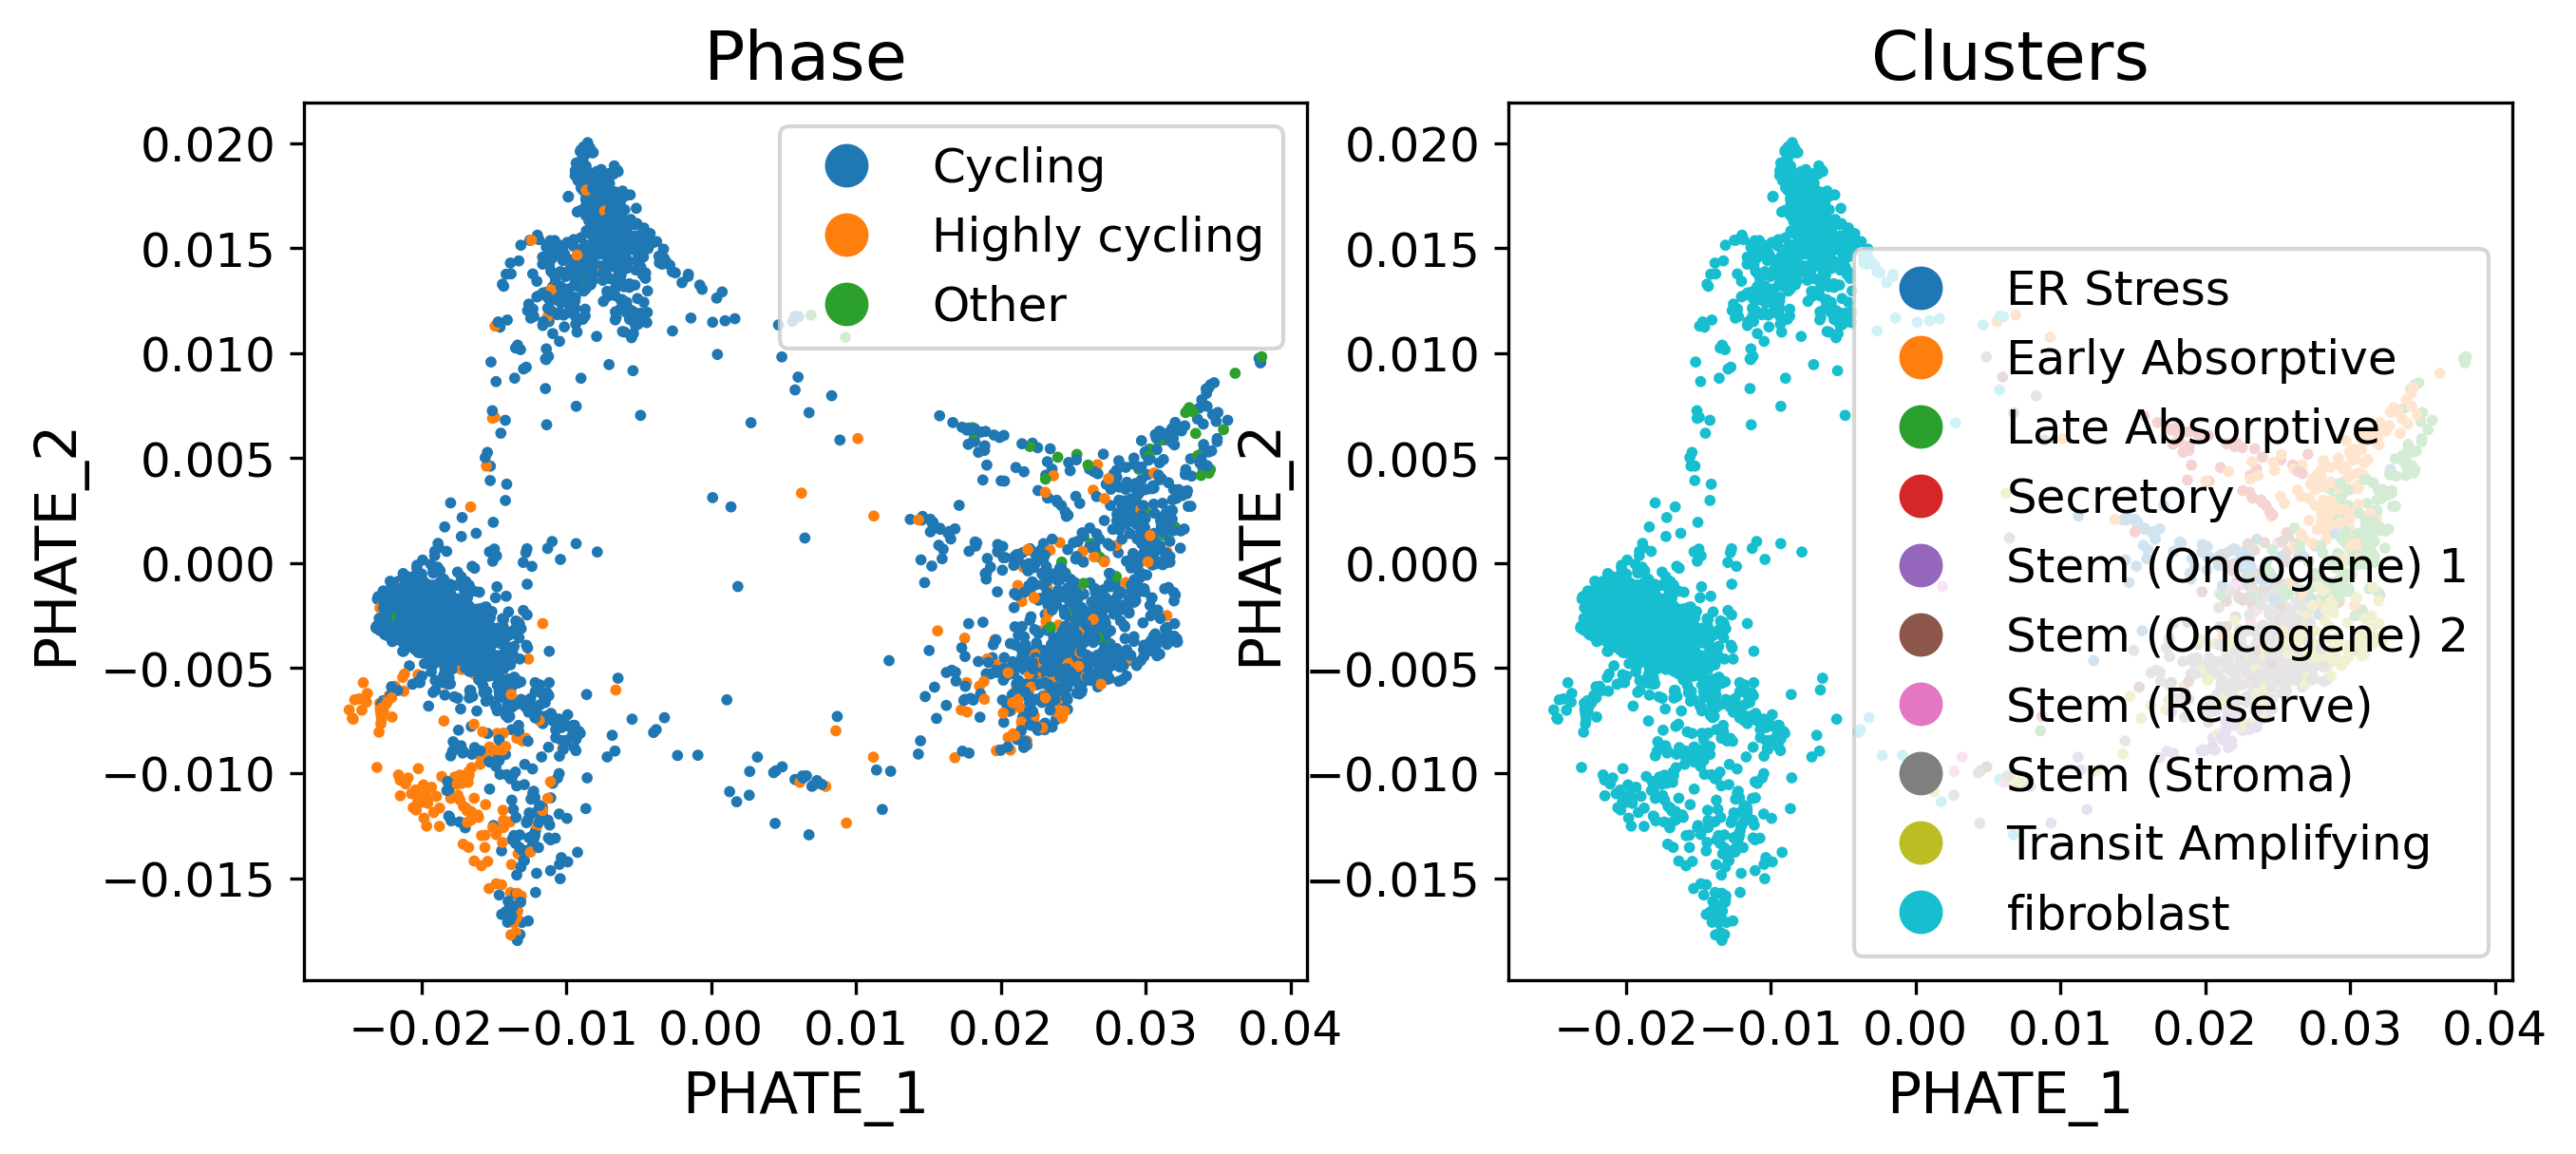

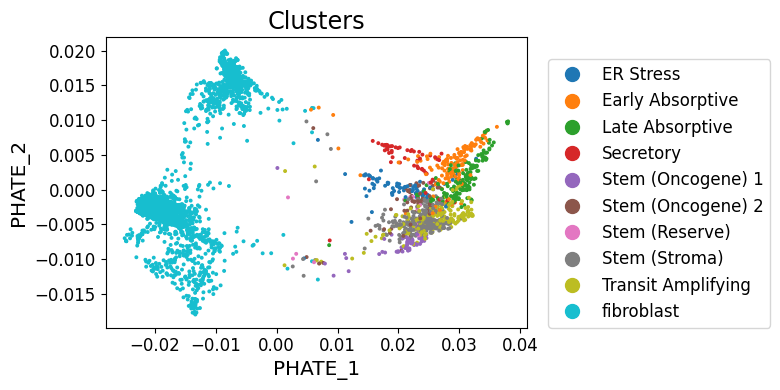

In [6]:
print(dRnaSeq.obsm)#No DimRed were ported over
#Add phate dims and view
dRnaSeq.obsm["X_PHATE"] = dPHATEcoord
del dPHATEcoord


fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=300); ax=ax.flatten()
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.Phase, figsize=(4.8,3),
    title=f"Phase", ax=ax[0])
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.finalPOPS, figsize=(4.8,3),
    title=f"Clusters", ax=ax[1])

scprep.plot.scatter2d(
    dRnaSeq.obsm["X_PHATE"], 
    c=dRnaSeq.obs.finalPOPS, 
    title=f"Clusters", 
    legend_loc=(1.05, 0), shuffle=True,
    figsize=(8,4), dpi=480)

print(f"Before filtering we have {len(dRnaSeq.var_names)} genes")
scanpy.pp.filter_genes(dRnaSeq, min_cells=4, inplace=True)
print(f"After filtering genes expressed in fewer than 4 cells we have {len(dRnaSeq.var_names)}")

dRnaSeq

In [7]:
cluster_colours = {
    "ER Stress":"#CC00FF",
    "Early Absorptive":"#00FF99",
    "Secretory":"#CC9900",
    "Late Absorptive":"#006600",
    "Stem (Oncogene) 2":"#6666FF", #CSC
    "Stem (Oncogene) 1":"#000099", #proCSC
    "Stem (Stroma)":"#CC0000", #revCSC
    "Transit Amplifying":"#FF99CC", #TA1
    "Stem (Reserve)":"#FF6666", #TA2
    "fibroblast":"darkgrey"
}

/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


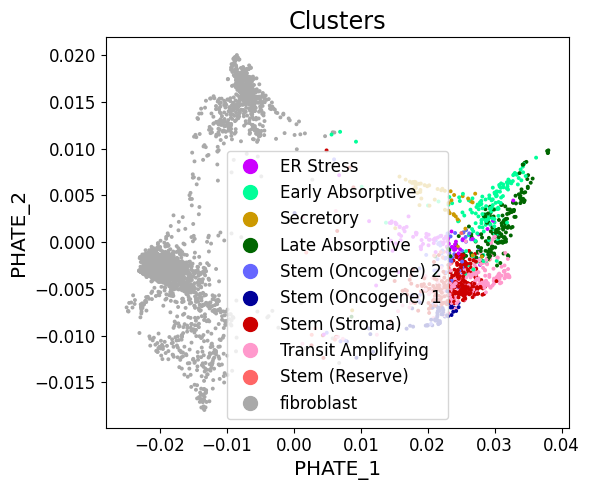

In [8]:
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.finalPOPS, figsize=(6,5),
    title=f"Clusters", dpi=480, cmap = cluster_colours)
plt.savefig(f"seq_clusters.pdf")

### Process data to human
Convert SEQ data to HGNC symbols

In [9]:
from biomart import BiomartServer

mart = BiomartServer("http://www.ensembl.org/biomart").datasets["mmusculus_gene_ensembl"]
# mart.show_attributes()
# for i in mart.show_attributes_by_page():
#     print(i)

response = mart.search({"attributes":["external_gene_name",
            "hsapiens_homolog_associated_gene_name"]})

mouse2human = []
for line in response.raw.data.decode("utf-8").splitlines():
    line = line.split("\t")
    if len(line[0]) > 0: #Only get gene symbols with ENSP ID
        mouse2human.append(line)
mouse2human = pd.DataFrame(mouse2human, 
                columns=["mgi_symbol","hgnc_symbol"]
                ).drop_duplicates() 
mouse2human = mouse2human.set_index("mgi_symbol"
                ).to_dict(
                    #Transform DF into a dictionary but first set index
                )["hgnc_symbol"]#Nested dict, so get first (and only item)


In [10]:
dSEQmd = dRnaSeq.obs
dRnaSeq = dRnaSeq.to_df(layer="logcounts").rename(columns=mouse2human).drop(
            columns=[""])
#After conversion some columns get duplicated. Group by them and average their gene expression
dRnaSeq = dRnaSeq.groupby(by=dRnaSeq.columns, axis=1).mean()
dRnaSeq

,0610010F05Rik,0610012G03Rik,1110008P14Rik,1110012L19Rik,1110032A03Rik,1110051M20Rik,1190007I07Rik,1300017J02Rik,1500009C09Rik,1520401A03Rik,...,ZYX,ZZEF1,ZZZ3,Zfp91.1,Zkscan7.1,Znrd1,Znrd1as,n-R5-8s1,pEGFP,partDsRedE
WT__AAACCCACAGCTTCCT-1,0.0,1.050319,1.050319,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.657148,0.657148,0.657148,0.000000,0.0,1.050319,0.657148,0.0,0.0,0.657148
WT__AAACCCAGTTCGAGCC-1,0.0,0.829238,0.498218,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.498218,0.000000,0.829238,0.000000,0.0,1.077511,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGAAGGATG-1,0.0,1.028759,1.222830,0.000000,0.000000,0.469502,1.028759,0.0,0.0,0.0,...,1.028759,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGGAAAGGT-1,0.0,1.006978,1.006978,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,1.006978,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGTTAACGA-1,0.0,1.006380,1.497693,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.221506,0.000000,0.221506,0.0,0.556103,0.221506,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.0,0.695505,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.695505,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__TTTGGTTTCCGTAGTA-1,0.0,0.824283,0.494771,0.000000,0.494771,0.494771,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,1.071710,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.494771
WT__TTTGTTGTCGCTTGAA-1,0.0,0.000000,0.461624,0.461624,0.000000,0.000000,0.461624,0.0,0.0,0.0,...,0.461624,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__TTTGTTGTCTGAATCG-1,0.0,1.267235,1.184048,0.882624,0.249549,0.249549,0.000000,0.0,0.0,0.0,...,0.993504,0.000000,0.000000,0.000000,0.0,0.882624,0.000000,0.0,0.0,0.000000


### Pre-processing: MAGIC

Use MAGIC with all genes to denoise, smooth and inpute missing values.
Return only genes in KG.

In [11]:
# magic_op = magic.MAGIC(
#     knn=5, # knn_max set to 3*knn by default
#     knn_dist="euclidean",
#     decay=1, t=3, n_pca=100, random_state=12,
#     n_jobs=-2 #All but one
#                         )

# dMagicRnaSeq = magic_op.fit_transform(
#     X = dRnaSeq,
#     genes = dRnaSeq.columns[dRnaSeq.columns.isin(entityIDS.values())]
# )
# del magic_op,dRnaSeq
# dMagicRnaSeq

In [12]:
dRnaSeq

,0610010F05Rik,0610012G03Rik,1110008P14Rik,1110012L19Rik,1110032A03Rik,1110051M20Rik,1190007I07Rik,1300017J02Rik,1500009C09Rik,1520401A03Rik,...,ZYX,ZZEF1,ZZZ3,Zfp91.1,Zkscan7.1,Znrd1,Znrd1as,n-R5-8s1,pEGFP,partDsRedE
WT__AAACCCACAGCTTCCT-1,0.0,1.050319,1.050319,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.657148,0.657148,0.657148,0.000000,0.0,1.050319,0.657148,0.0,0.0,0.657148
WT__AAACCCAGTTCGAGCC-1,0.0,0.829238,0.498218,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.498218,0.000000,0.829238,0.000000,0.0,1.077511,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGAAGGATG-1,0.0,1.028759,1.222830,0.000000,0.000000,0.469502,1.028759,0.0,0.0,0.0,...,1.028759,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGGAAAGGT-1,0.0,1.006978,1.006978,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,1.006978,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGTTAACGA-1,0.0,1.006380,1.497693,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.221506,0.000000,0.221506,0.0,0.556103,0.221506,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.0,0.695505,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.695505,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__TTTGGTTTCCGTAGTA-1,0.0,0.824283,0.494771,0.000000,0.494771,0.494771,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,1.071710,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.494771
WT__TTTGTTGTCGCTTGAA-1,0.0,0.000000,0.461624,0.461624,0.000000,0.000000,0.461624,0.0,0.0,0.0,...,0.461624,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__TTTGTTGTCTGAATCG-1,0.0,1.267235,1.184048,0.882624,0.249549,0.249549,0.000000,0.0,0.0,0.0,...,0.993504,0.000000,0.000000,0.000000,0.0,0.882624,0.000000,0.0,0.0,0.000000


Calculating PHATE...
  Running PHATE on 3698 observations and 13804 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 7.17 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.44 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 7.78 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.25 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.81 seconds.
  Calculated landmark operator in 6.18 seconds.
  Calculating optimal t...
    Automatically selected t = 28
  Calculated optimal t in 2.19 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.07 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 8.06 seconds.
Calculated PHATE in 25.30 seconds.


/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'Logcounts (col=clust)'}>

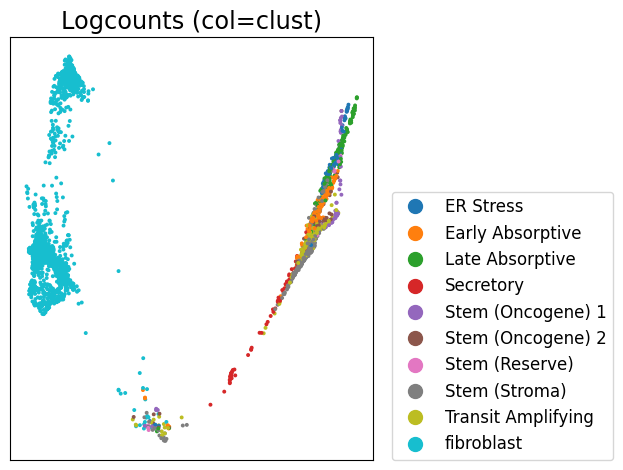

In [13]:
data_phate = phate.PHATE(n_jobs=-2, random_state=12).fit_transform(dRnaSeq) 
scprep.plot.scatter2d(
    data_phate, c=dSEQmd["finalPOPS"],
    title=f"Logcounts (col=clust)",
    shuffle=True, ticks=None,
    legend_loc=(1.05, 0))

### Scale MAGIC normalised data

In [14]:
# #Cell-scalled GEX:
# dScalRnaSeq = dRnaSeq.div(dRnaSeq.sum(axis=1), axis=0)
# dScalRnaSeq

### Match genes in KG and scRNA-seq

In [15]:
import json
with open(f"{data_dir}/customLRT_KGEtransr_entityIDS.json") as infile:
    customLRT_entityIDS = json.load(infile)

with open(f"{data_dir}/customLRT_KGEtransr_relationIDS.json") as infile:
    customLRT_relationIDS = json.load(infile)

In [16]:
import json
with open(f"{data_dir}/omnipath_KGEtransr_entityIDS.json") as infile:
    omnipath_entityIDS = json.load(infile)

with open(f"{data_dir}/omnipath_KGEtransr_relationIDS.json") as infile:
    omnipath_relationIDS = json.load(infile)

In [17]:
dRnaSeq_customLRT = dRnaSeq.reindex(columns=list(customLRT_entityIDS.values()), fill_value=float("0"))
dRnaSeq_customLRT

,AAAS,AAMP,AATF,ABCC1,ABCD3,ABCG1,ABCG5,ABCG8,ABHD12,ABHD17C,...,ZDHHC21,ZDHHC7,ZDHHC9,ZFYVE16,ZNF217,ZNRF3,ZRANB1,ZW10,ZWILCH,ZWINT
WT__AAACCCACAGCTTCCT-1,0.000000,1.050319,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.050319,0.000000,...,0.000000,0.657148,0.000000,0.0,0.000000,0.0,0.657148,0.000000,0.0,0.000000
WT__AAACCCAGTTCGAGCC-1,0.000000,0.829238,0.498218,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.498218,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
WT__AAACGAAAGAAGGATG-1,0.000000,0.469502,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.469502,0.0,0.000000,0.0,0.000000,0.469502,0.0,0.469502
WT__AAACGAAAGGAAAGGT-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.498425,...,2.073080,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.006978
WT__AAACGAAAGTTAACGA-1,0.000000,0.000000,0.000000,0.0,0.221506,0.0,0.000000,0.0,0.000000,0.000000,...,0.221506,0.000000,0.000000,0.0,0.221506,0.0,0.000000,0.000000,0.0,0.911369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.000000,0.000000,0.000000,0.0,0.695505,0.0,0.000000,0.0,0.695505,1.101755,...,0.000000,0.695505,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.101755
WT__TTTGGTTTCCGTAGTA-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.824283,0.000000,0.000000,0.0,0.494771,0.0,0.000000,0.000000,0.0,0.494771
WT__TTTGTTGTCGCTTGAA-1,0.000000,0.000000,0.000000,0.0,0.461624,0.0,0.776245,0.0,0.000000,1.207942,...,0.461624,0.000000,0.461624,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
WT__TTTGTTGTCTGAATCG-1,0.249549,1.184048,0.000000,0.0,0.249549,0.0,0.000000,0.0,0.757898,0.757898,...,0.249549,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.249549,0.0,1.481914


Calculating PHATE...
  Running PHATE on 3698 observations and 2507 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.49 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.58 seconds.
    Calculating affinities...
    Calculated affinities in 0.07 seconds.
  Calculated graph and diffusion operator in 2.22 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.30 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.42 seconds.
  Calculated landmark operator in 5.64 seconds.
  Calculating optimal t...
    Automatically selected t = 19
  Calculated optimal t in 2.04 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.66 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 8.27 seconds.
Calculated PHATE in 18.84 seconds.


/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'Logcounts (col=clust)'}>

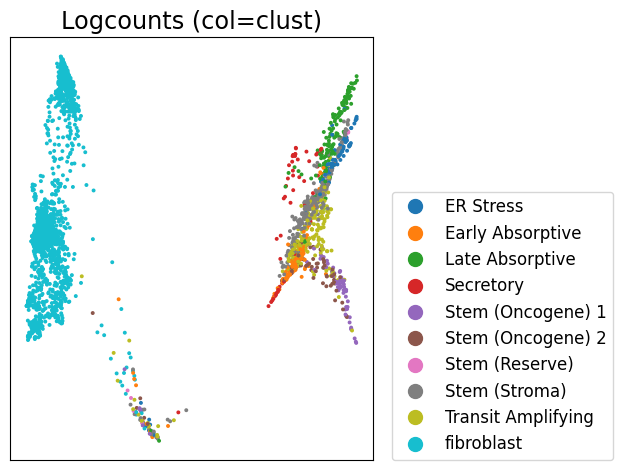

In [18]:
data_phate = phate.PHATE(n_jobs=-2, random_state=12).fit_transform(dRnaSeq_customLRT) 
scprep.plot.scatter2d(
    data_phate, c=dSEQmd["finalPOPS"],
    title=f"Logcounts (col=clust)",
    shuffle=True, ticks=None,
    legend_loc=(1.05, 0))

In [96]:
dRnaSeq_omnipath = dRnaSeq.reindex(columns=list(omnipath_entityIDS.values()), fill_value=float("0"))
dRnaSeq_omnipath

,A1BG,A2M,AAAS_AHCTF1_GLE1_NDC1_NUP107_NUP133_NUP153_NUP155_NUP160_NUP188_NUP205_NUP210_NUP214_NUP35_NUP37_NUP42_NUP43_NUP50_NUP54_NUP58_NUP62_NUP85_NUP88_NUP93_NUP98_POM121_RAE1_RANBP2_SEC13_SEH1L_TPR,AAK1,AANAT,AATF,AATK,ABCA1,ABCA7,ABCB1,...,ZP3,ZPBP2,ZPR1,ZRANB1,ZRANB2,ZSWIM2,ZW10,ZWINT,ZXDC,ZYX
WT__AAACCCACAGCTTCCT-1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.657148,0.657148,0.0,0.000000,0.000000,0.000000,0.657148
WT__AAACCCAGTTCGAGCC-1,0.0,0.0,0.0,0.829238,0.0,0.498218,0.0,0.000000,0.498218,0.249109,...,0.0,0.0,0.000000,0.000000,1.441949,0.0,0.000000,0.000000,0.000000,0.498218
WT__AAACGAAAGAAGGATG-1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,1.028759,0.0,0.469502,0.469502,0.469502,1.028759
WT__AAACGAAAGGAAAGGT-1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.503489,...,0.0,0.0,0.000000,0.000000,1.006978,0.0,0.000000,1.006978,0.000000,0.000000
WT__AAACGAAAGTTAACGA-1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.403187,...,0.0,0.0,0.000000,0.000000,0.806374,0.0,0.000000,0.911369,0.221506,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.0,0.0,0.0,0.695505,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,1.613209,0.0,0.000000,1.101755,0.000000,0.000000
WT__TTTGGTTTCCGTAGTA-1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.824283,0.0,0.000000,0.494771,0.000000,0.000000
WT__TTTGTTGTCGCTTGAA-1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.230812,...,0.0,0.0,0.000000,0.000000,0.461624,0.0,0.000000,0.000000,0.000000,0.461624
WT__TTTGTTGTCTGAATCG-1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.249549,0.249549,0.000000,...,0.0,0.0,0.449095,0.000000,0.757898,0.0,0.249549,1.481914,0.000000,0.993504


Calculating PHATE...
  Running PHATE on 3698 observations and 9248 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.94 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.50 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 5.66 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.27 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.74 seconds.
  Calculated landmark operator in 4.97 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 2.00 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.79 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 8.21 seconds.
Calculated PHATE in 21.63 seconds.


/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'Logcounts (col=clust)'}>

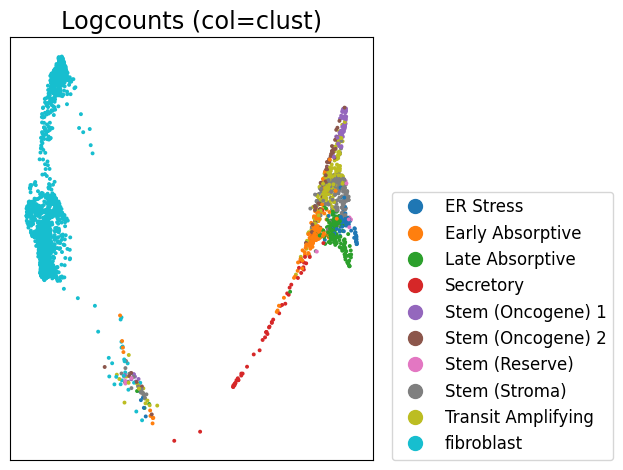

In [97]:
data_phate = phate.PHATE(n_jobs=-2, random_state=12).fit_transform(dRnaSeq_omnipath) 
scprep.plot.scatter2d(
    data_phate, c=dSEQmd["finalPOPS"],
    title=f"Logcounts (col=clust)",
    shuffle=True, ticks=None,
    legend_loc=(1.05, 0))

## customLRT KGE

In [19]:
dKGlrt = pd.read_csv(f"{data_dir}/dKGlrt.csv.tar.gz", header=None)
dKGlrt

,0,1,2
0,CXCL1,Signaling by GPCR,CXCR2
1,CXCL2,Signaling by GPCR,CXCR2
2,CXCL3,Signaling by GPCR,CXCR2
3,CXCL5,Signaling by GPCR,CXCR2
4,PPBP,Signaling by GPCR,CXCR2
...,...,...,...
97052,LGR4,Signaling by WNT,HIST1H2BO
97053,LGR4,Signaling by WNT,HIST1H2BH
97054,LGR4,Signaling by WNT,PSMB3
97055,LGR4,Signaling by WNT,HIST1H2BB


In [20]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

modelKGE = "customLRT_50_unstratified_stopped_TransR"

tf = TriplesFactory.from_labeled_triples(
        dKGlrt.to_numpy(dtype="str"),create_inverse_triples=("inverse" in modelKGE))
print(tf)

try:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl")
except RuntimeError:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl",
    map_location=torch.device("cpu"))

print(trained_model)

TriplesFactory(num_entities=2507, num_relations=23, create_inverse_triples=False, num_triples=97057)
TransR(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransRInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(2507, 50)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(23, 30)
    )
    (1): Embedding(
      (_embeddings): Embedding(23, 1500)
    )
  )
  (weight_regularizers): ModuleList()
)


In [21]:
#Construct nodes dataframe: detach() for now is meaningless as compute is CPU
entity_embeddings = trained_model.entity_representations[0](indices=None).detach().cpu().numpy()
KGEcustomLRT = pd.DataFrame(entity_embeddings, index=customLRT_entityIDS.values())
KGEcustomLRT

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
AAAS,-0.201149,-0.218883,0.020049,0.288104,-0.066969,0.170632,-0.322887,-0.079326,-0.101365,0.022392,...,0.053724,0.061619,-0.245615,-0.110809,0.073288,-0.063230,-0.073141,-0.029983,-0.189481,-0.039863
AAMP,0.020951,-0.291592,0.138468,-0.031830,0.037229,0.097661,-0.178221,-0.361847,-0.107483,-0.171954,...,-0.029712,-0.056342,-0.044399,-0.103038,-0.104707,0.109106,0.094820,-0.108496,0.069959,-0.043669
AATF,0.085083,-0.094235,-0.017311,0.234901,0.062033,-0.097160,0.049620,0.137447,-0.006073,0.163676,...,0.206305,0.214235,-0.082344,-0.094646,-0.146063,0.066738,0.252404,-0.203899,-0.296347,-0.032439
ABCC1,-0.119740,-0.185241,0.173619,0.149668,-0.315456,0.076847,-0.173103,-0.193997,-0.217596,-0.176079,...,0.227803,-0.057589,-0.114751,-0.017054,-0.018978,0.033963,0.081139,-0.015416,-0.249233,0.108095
ABCD3,-0.112624,-0.023640,-0.127329,0.056583,0.007089,0.024257,-0.090809,0.040193,-0.170463,0.002029,...,0.023380,-0.002311,0.091811,0.071431,-0.063530,-0.006602,-0.071628,-0.168155,-0.240646,-0.123966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNRF3,-0.023284,-0.043150,0.093468,0.016122,-0.133373,-0.048538,-0.142818,0.142023,0.080462,0.110987,...,-0.196290,0.121376,0.031408,-0.052333,0.071770,0.071192,0.161012,0.143996,0.084458,0.266876
ZRANB1,0.168557,-0.082377,0.124859,-0.045588,0.080119,-0.154988,-0.111201,0.090919,0.056552,0.019166,...,-0.163922,0.196450,-0.027047,-0.145925,0.053214,0.039090,0.064877,0.120903,-0.099010,0.097119
ZW10,-0.043946,-0.221952,0.120424,-0.141735,0.245929,0.035207,0.069325,0.133197,-0.094728,0.343620,...,-0.114138,0.186758,-0.090189,0.019934,0.140588,0.194385,0.149962,-0.198785,0.053518,-0.238291
ZWILCH,0.047290,-0.173978,-0.212108,0.104762,-0.099421,0.121642,-0.278216,0.059533,-0.235186,0.136705,...,-0.103069,0.245683,-0.171601,0.266093,-0.068662,0.198846,-0.146907,0.177667,-0.038137,-0.133198


## omnipath KGE


In [88]:
dOMNIpath = pd.read_csv(f"{data_dir}/dOMNIpath.csv.tar.gz")
dOMNIpath

,source_genesymbol,pathway,target_genesymbol
0,CALM3,undetermined,TRPC1
1,CALM2,undetermined,TRPC1
2,CALM1,undetermined,TRPC1
3,CAV1,undetermined,TRPC1
4,DRD2,undetermined,TRPC1
...,...,...,...
94831,MET,Signaling by Receptor Tyrosine Kinases,HGS
94832,MET,Signaling by Receptor Tyrosine Kinases,RANBP10
94833,LCK,undetermined,CD44
94834,ERBB2,Signaling by Receptor Tyrosine Kinases,SOS1


In [89]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

modelKGE = "omnipath_50_unstratified_stopped_TransR"

tf = TriplesFactory.from_labeled_triples(
        dOMNIpath.to_numpy(dtype="str"),create_inverse_triples=("inverse" in modelKGE))
print(tf)

try:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl")
except RuntimeError:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl",
    map_location=torch.device("cpu"))

print(trained_model)

TriplesFactory(num_entities=9248, num_relations=34, create_inverse_triples=False, num_triples=94836)
TransR(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransRInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(9248, 50)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(34, 30)
    )
    (1): Embedding(
      (_embeddings): Embedding(34, 1500)
    )
  )
  (weight_regularizers): ModuleList()
)


In [90]:
#Construct nodes dataframe: detach() for now is meaningless as compute is CPU
entity_embeddings = trained_model.entity_representations[0](indices=None).detach().cpu().numpy()
KGEomnipath = pd.DataFrame(entity_embeddings, index=omnipath_entityIDS.values())
KGEomnipath

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
A1BG,0.168749,-0.115078,-0.284815,0.136267,0.050776,-0.195221,-0.011114,-0.001942,-0.091480,-0.115033,...,-0.136144,0.191162,0.059513,0.043871,-0.132613,-0.154810,-0.245956,-0.150547,-0.031841,-0.115345
A2M,-0.171674,-0.064670,0.052996,-0.068624,-0.046354,-0.098046,0.236560,-0.013534,0.178363,0.015394,...,-0.093867,0.081763,-0.159688,0.097931,-0.028741,-0.020183,0.184809,-0.319230,-0.163206,0.006041
AAAS_AHCTF1_GLE1_NDC1_NUP107_NUP133_NUP153_NUP155_NUP160_NUP188_NUP205_NUP210_NUP214_NUP35_NUP37_NUP42_NUP43_NUP50_NUP54_NUP58_NUP62_NUP85_NUP88_NUP93_NUP98_POM121_RAE1_RANBP2_SEC13_SEH1L_TPR,0.016916,0.059035,0.081082,-0.051270,-0.126972,-0.185547,-0.195467,-0.174221,-0.022048,0.094809,...,-0.020118,0.084224,-0.223350,-0.093606,-0.115414,0.313520,0.007840,0.234518,0.090897,-0.023346
AAK1,-0.031832,-0.069830,-0.120497,0.013276,0.250261,0.226753,-0.163884,0.122832,0.145507,0.152419,...,0.212164,0.209348,-0.271362,-0.065723,0.129874,0.074858,0.180683,-0.129777,-0.131210,0.223652
AANAT,-0.050789,0.026697,0.032373,0.296229,-0.148040,-0.011147,0.016159,-0.175297,0.105730,-0.031381,...,-0.116404,-0.079715,0.167580,-0.172420,0.039863,-0.206487,-0.300214,-0.209653,0.190827,-0.094137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSWIM2,0.218658,0.068080,-0.205122,-0.118409,0.054787,0.024513,-0.144079,0.199494,-0.065039,-0.057872,...,-0.136822,0.252353,-0.101827,0.114271,-0.150328,0.009771,0.036610,0.143896,0.043302,0.081284
ZW10,-0.081173,0.091789,-0.031350,0.059798,-0.179222,0.032429,-0.029622,0.056066,-0.197992,0.138027,...,-0.082527,-0.241609,0.006250,0.056161,0.196974,0.197980,0.066818,-0.136562,0.156254,0.074561
ZWINT,0.162270,-0.055928,-0.063938,-0.123214,-0.104072,-0.087757,0.048259,0.065016,-0.080204,-0.157709,...,-0.146367,0.122455,-0.063385,0.058995,0.067579,0.225262,0.020177,0.198606,0.032809,-0.048729
ZXDC,-0.032551,-0.044964,-0.132640,0.072477,0.133302,-0.162599,-0.057085,0.259096,-0.052903,0.041053,...,-0.027811,0.236141,-0.095779,0.074155,-0.177789,-0.189098,-0.088654,0.084450,0.094621,0.093738


# Wavelet dictionaries

Compute knn graph based on KGE

In [22]:
knnKGEcustomLRT = sklearn.neighbors.kneighbors_graph(
    KGEcustomLRT, n_neighbors = 5, mode = "connectivity",
    n_jobs = -2
)
print(knnKGEcustomLRT.toarray())
pyG_customLRT = pygsp.graphs.Graph(W=knnKGEcustomLRT)
print(pyG_customLRT.check_weights())
print(pyG_customLRT.is_connected())
print(pyG_customLRT.is_directed())
# pyG_customLRT.set_coordinates()
# pyG_customLRT.plot()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
{'has_inf_val': False, 'has_nan_value': False, 'is_not_square': False, 'diag_is_not_zero': False}
False
True


/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/pygsp/plotting.py:274: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(G.coords[:, 0], G.coords[:, 1], marker='o',


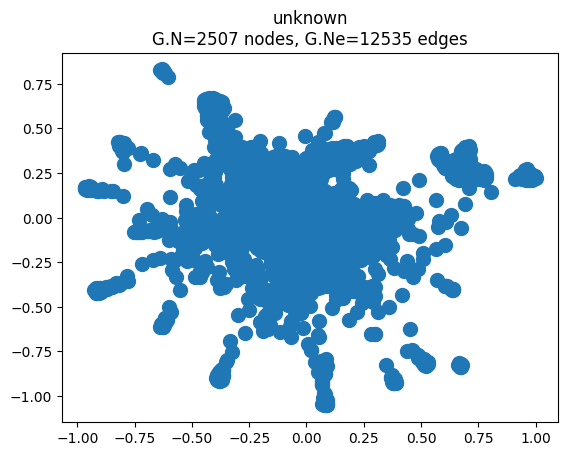

In [23]:
pyG_customLRT.set_coordinates()
pyG_customLRT.plot()

In [91]:
knnKGEomnipath = sklearn.neighbors.kneighbors_graph(
    KGEomnipath, n_neighbors = 5, mode = "connectivity",
    n_jobs = -2
)
print(knnKGEomnipath.toarray())
pyG_omnipath = pygsp.graphs.Graph(W=knnKGEomnipath)
print(pyG_omnipath.check_weights())
print(pyG_omnipath.is_connected())
print(pyG_omnipath.is_directed())
# pyG_omnipath.set_coordinates()
# pyG_omnipath.plot()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
{'has_inf_val': False, 'has_nan_value': False, 'is_not_square': False, 'diag_is_not_zero': False}
False
True


/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/pygsp/plotting.py:274: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(G.coords[:, 0], G.coords[:, 1], marker='o',


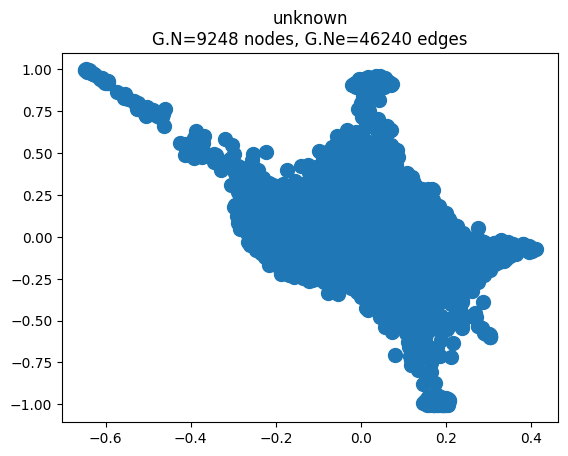

In [92]:
pyG_omnipath.set_coordinates()
pyG_omnipath.plot()

In [43]:
wavloc_customLRT = Localizer(pyG_customLRT) #Takes only pygsp graphs
wavloc_customLRT.CalculateWavelets(J=4) #J is the scale param.
wavloc_customLRT.FlattenAndNormalize()
print(wavloc_customLRT.FlatWaves.shape)
wavloc_customLRT.FlatWaves

Calculating Wavelets Using J = 4


100%|██████████| 2/2 [00:00<00:00,  3.02it/s]


Flattening and Normalizing Wavelets


100%|██████████| 4/4 [00:00<00:00,  7.39it/s]

(2507, 10028)


array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.96385541e-06, -6.46946654e-03,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
        -4.82122036e-06, -1.63128730e-04,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         7.24769986e-01, -7.51774980e-03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.36976227e-03,  6.41569914e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.16633502e-04, -1.48217906e-02,  1.00000000e+00]])

When computing wavelets on multigraphs we get wavelets with NaN entries

In [44]:
pd.DataFrame(wavloc_customLRT.FlatWaves, index=list(customLRT_entityIDS.values()))

,0,1,2,3,4,5,6,7,8,9,...,10018,10019,10020,10021,10022,10023,10024,10025,10026,10027
AAAS,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,-0.000010,-6.469467e-03,0.0
AAMP,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-5.745428e-05,-8.711602e-08,0.000000e+00,0.0,-8.812016e-06,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0
AATF,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.013624e-06,-4.094453e-06,-1.431682e-07,0.0,-2.731725e-04,-4.337518e-07,-3.464612e-06,-0.000005,-1.631287e-04,0.0
ABCC1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,-4.007337e-06,-7.158411e-08,0.0,-1.980228e-07,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0
ABCD3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,-2.168759e-07,-3.387620e-06,-0.006657,-8.199030e-03,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNRF3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.432636e-08,0.000000e+00,0.000000e+00,0.0,-1.156453e-04,5.436291e-01,1.810754e-01,0.000000,-3.401596e-06,0.0
ZRANB1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.432636e-08,0.000000e+00,0.000000e+00,0.0,-9.010038e-05,2.407744e-01,6.314649e-01,0.000000,-3.697387e-07,0.0
ZW10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.432636e-08,0.000000e+00,0.000000e+00,0.0,0.000000e+00,-9.831708e-06,-6.944621e-05,0.724770,-7.517750e-03,0.0
ZWILCH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,-2.309741e-07,-0.001370,6.415699e-01,0.0


In [46]:
#Compute version with gex identity removed

wavloc_pruned = Localizer(pyG_customLRT) #Takes only pygsp graphs
wavloc_pruned.CalculateWavelets(J=4) #J is the scale param.
wavloc_pruned.FlattenAndNormalize()
print(wavloc_pruned.FlatWaves.shape)
wavloc_pruned.FlatWaves

wavloc_pruned.wavelets = wavloc_pruned.wavelets[1:10]
wavloc_pruned.Precomputed = False
wavloc_pruned.J = wavloc_pruned.J - 1
print("Setting wavelet diagonals to Zero")
for i in range(wavloc_pruned.J):
    np.fill_diagonal(wavloc_pruned.wavelets[i], 0)
    if np.sum(wavloc_pruned.wavelets[i]) == 0:
        print("this is empty")
        print(i)
        print("YOU SHOULD NEVER SEE THIS MESSAGE!")
wavloc_pruned.FlattenAndNormalize()
print(wavloc_pruned.FlatWaves.shape)
wavloc_pruned.FlatWaves
wavloc_pruned.FlatWaves = wavloc_pruned.FlatWaves[:,~np.all(np.isnan(wavloc_pruned.FlatWaves), axis=0)] #Any and all do the same
wavloc_pruned.FlatWaves

Calculating Wavelets Using J = 4


100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


Flattening and Normalizing Wavelets


100%|██████████| 4/4 [00:00<00:00,  7.33it/s]


(2507, 10028)
Setting wavelet diagonals to Zero
Flattening and Normalizing Wavelets


  0%|          | 0/3 [00:00<?, ?it/s]/var/home/ferran/PhD/yaleCollab/localization.py:141: RuntimeWarning: invalid value encountered in divide
  A[:,i]=A[:,i]/np.linalg.norm(A[:,i])
100%|██████████| 3/3 [00:00<00:00,  9.56it/s]


(2507, 7521)


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -1.44615195e-05, -8.43405737e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.46813484e-06, -6.99750943e-06, -2.12666231e-04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.95612805e-05,  0.00000000e+00, -9.80067409e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.97875656e-07, -1.98807018e-03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.97167541e-07, -3.14421424e-04, -1.93227419e-02]])

In [42]:
# del wavloc_customLRT
# del wavloc_pruned
# del wavloc_customLRT_PRUNED

In [47]:
print(wavloc_customLRT.FlatWaves.shape)
print(wavloc_pruned.FlatWaves.shape)

(2507, 10028)
(2507, 7116)


In [93]:
wavloc_omnipath = Localizer(pyG_omnipath) #Takes only pygsp graphs
wavloc_omnipath.CalculateWavelets(J=4) #J is the scale param.
wavloc_omnipath.FlattenAndNormalize()
print(wavloc_omnipath.FlatWaves.shape)
wavloc_omnipath.FlatWaves

Calculating Wavelets Using J = 4


100%|██████████| 2/2 [00:14<00:00,  7.38s/it]


Flattening and Normalizing Wavelets


100%|██████████| 4/4 [00:05<00:00,  1.27s/it]

(9248, 36992)


array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -7.97849413e-08,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
        -1.91832827e-07,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         7.17870665e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  6.89477208e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.11452857e-05, -1.31645153e-05,  1.00000000e+00]])

In [94]:
pd.DataFrame(wavloc_omnipath.FlatWaves, index=list(omnipath_entityIDS.values()))

,0,1,2,3,4,5,6,7,8,9,...,36982,36983,36984,36985,36986,36987,36988,36989,36990,36991
A1BG,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.024970e-04,-3.459647e-06,0.000000,0.000000e+00,-8.166821e-04,-1.394618e-07,0.000000e+00,0.000000e+00,-7.978494e-08,0.0
A2M,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.622247e-04,-1.323516e-04,-0.000011,0.000000e+00,-9.763086e-08,0.000000e+00,-7.219718e-06,0.000000e+00,0.000000e+00,0.0
AAAS_AHCTF1_GLE1_NDC1_NUP107_NUP133_NUP153_NUP155_NUP160_NUP188_NUP205_NUP210_NUP214_NUP35_NUP37_NUP42_NUP43_NUP50_NUP54_NUP58_NUP62_NUP85_NUP88_NUP93_NUP98_POM121_RAE1_RANBP2_SEC13_SEH1L_TPR,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,-2.091926e-07,-4.039604e-06,-1.918328e-07,0.000000e+00,0.0
AAK1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-6.157442e-05,-8.045691e-08,-0.003385,0.000000e+00,-9.763086e-08,-2.383401e-04,-1.718980e-07,-7.740455e-05,-1.595699e-07,0.0
AANAT,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-7.277670e-05,-7.080208e-06,-0.000005,-7.191357e-08,-9.763086e-08,-2.091926e-07,-7.649463e-05,0.000000e+00,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSWIM2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,5.221653e-01,0.000000e+00,0.000000e+00,-2.393548e-07,0.0
ZW10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-6.706125e-06,0.000000e+00,-0.000117,-3.164197e-06,-2.128353e-05,0.000000e+00,6.989786e-01,0.000000e+00,0.000000e+00,0.0
ZWINT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000,-6.745493e-04,-9.060144e-05,-8.367705e-07,0.000000e+00,7.178707e-01,0.000000e+00,0.0
ZXDC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,-3.098561e-03,0.000000e+00,0.000000e+00,6.894772e-01,0.0


# Project data

## Projection on customLRT

In [48]:
#Multiply 2 matrices using the dot product
customLRT_projection = np.dot(dRnaSeq_customLRT, wavloc_customLRT.FlatWaves)
print(customLRT_projection.shape) #Shape should be cellsXwavelets
customLRT_projection

(3698, 10028)


array([[ 0.        ,  1.05031917,  0.        , ...,  0.00575816,
        -0.97586335,  0.        ],
       [ 0.        ,  0.82923826,  0.49821823, ...,  0.05798967,
        -0.914011  ,  0.        ],
       [ 0.        ,  0.46950168,  0.        , ...,  0.2249843 ,
        -0.80843046,  0.46950168],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.20449632,
        -0.99477123,  0.        ],
       [ 0.2495492 ,  1.18404772,  0.        , ...,  0.03321873,
        -1.19397405,  1.48191371],
       [ 0.        ,  0.794661  ,  0.        , ..., -0.20135029,
        -1.03321458,  0.59284438]])

In [49]:
print(np.isnan(np.sum(customLRT_projection)))

False


In [50]:
from sklearn.impute import SimpleImputer
customLRT_projection = SimpleImputer(strategy="constant").fit_transform(customLRT_projection)
print(np.isnan(np.sum(customLRT_projection)))

False


Calculating PHATE...
  Running PHATE on 3698 observations and 10028 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 6.28 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.53 seconds.
    Calculating affinities...
    Calculated affinities in 0.06 seconds.
  Calculated graph and diffusion operator in 6.89 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.31 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.80 seconds.
  Calculated landmark operator in 6.05 seconds.
  Calculating optimal t...
    Automatically selected t = 28
  Calculated optimal t in 2.12 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.81 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 8.52 seconds.
Calculated PHATE in 24.41 seconds.


/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'scRNAseq customLRT (col=clust)'}>

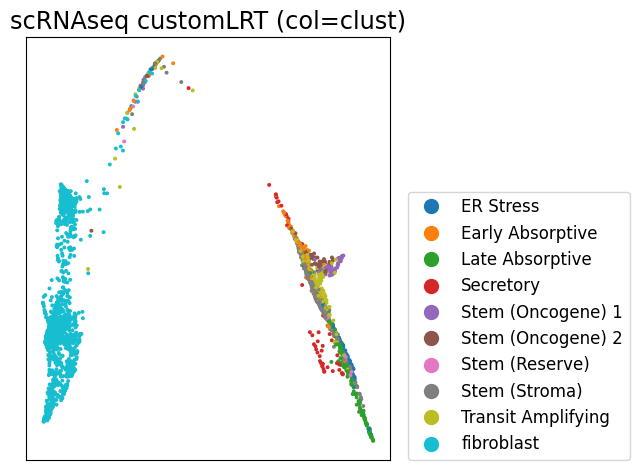

In [51]:
data_phate = phate.PHATE(n_jobs=-2, random_state=12).fit_transform(customLRT_projection) 
scprep.plot.scatter2d(
    data_phate, c=dSEQmd["finalPOPS"],
    title=f"scRNAseq customLRT (col=clust)",
    shuffle=True, ticks=None,
    legend_loc=(1.05, 0))

/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


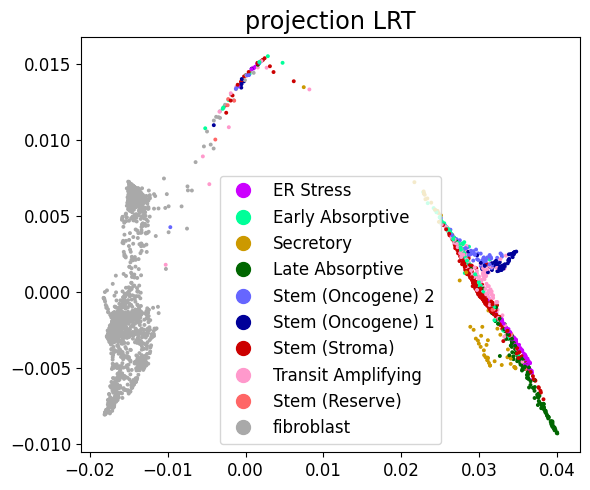

In [51]:
scprep.plot.scatter2d(data_phate, c=dSEQmd["finalPOPS"], figsize=(6,5),
    title=f"projection LRT", dpi=480, cmap = cluster_colours)
plt.savefig(f"projectionLRT_clusters.pdf")

Version with pruned wavelet bank

In [52]:
#Multiply 2 matrices using the dot product
customLRT_PRUNED_projection = np.dot(dRnaSeq_customLRT, wavloc_pruned.FlatWaves)
print(customLRT_PRUNED_projection.shape) #Shape should be cellsXwavelets
customLRT_PRUNED_projection

(3698, 7116)


array([[-0.70975079, -0.68765807, -0.92769985, ...,  0.00619821,
         0.00835739, -1.27220497],
       [-0.55266812, -0.52043914, -0.94059687, ...,  0.18606365,
         0.08416609, -1.19156984],
       [-1.02215671, -0.67607783, -0.60859907, ...,  0.04766259,
        -0.16734099, -1.05392752],
       ...,
       [-0.3685339 , -0.64201699, -0.31680024, ...,  0.0344364 ,
        -0.29680555, -1.29685463],
       [-1.01376956, -0.8708316 , -0.49538889, ...,  0.09820138,
        -0.21429462, -1.55654961],
       [-0.91534972, -0.4338676 , -0.33368541, ...,  0.3527563 ,
        -0.2922394 , -1.34697211]])

In [53]:
print(np.isnan(np.sum(customLRT_PRUNED_projection)))

False


In [54]:
from sklearn.impute import SimpleImputer
customLRT_PRUNED_projection = SimpleImputer(strategy="constant").fit_transform(customLRT_PRUNED_projection)
print(np.isnan(np.sum(customLRT_PRUNED_projection)))

False


Calculating PHATE...
  Running PHATE on 3698 observations and 7116 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.63 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.50 seconds.
    Calculating affinities...
    Calculated affinities in 0.07 seconds.
  Calculated graph and diffusion operator in 5.21 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.28 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.39 seconds.
  Calculated landmark operator in 5.61 seconds.
  Calculating optimal t...
    Automatically selected t = 17
  Calculated optimal t in 1.99 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.67 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.85 seconds.
Calculated PHATE in 21.34 seconds.


/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'scRNAseq customLRT (col=clust)'}>

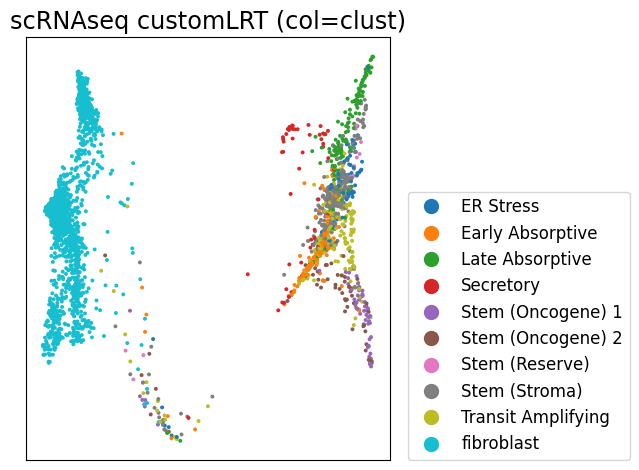

In [55]:
data_phate = phate.PHATE(n_jobs=-2, random_state=12).fit_transform(customLRT_PRUNED_projection) 
scprep.plot.scatter2d(
    data_phate, c=dSEQmd["finalPOPS"],
    title=f"scRNAseq customLRT (col=clust)",
    shuffle=True, ticks=None,
    legend_loc=(1.05, 0))

/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


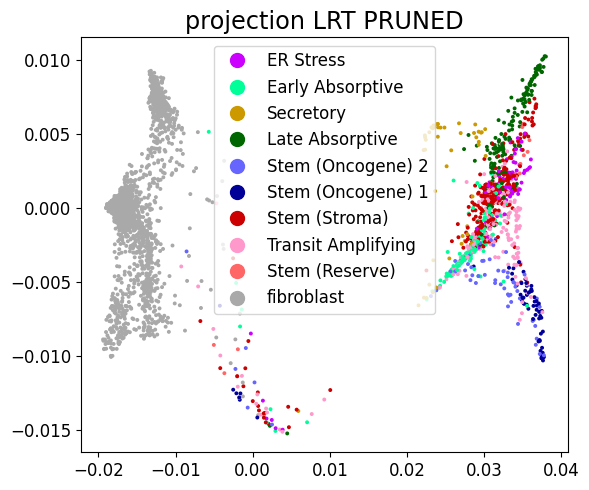

In [56]:
scprep.plot.scatter2d(data_phate, c=dSEQmd["finalPOPS"], figsize=(6,5),
    title=f"projection LRT PRUNED", dpi=480, cmap = cluster_colours)
plt.savefig(f"projectionLRT_PRUNED_clusters.pdf")

## Projection on omnipath

In [98]:
#Multiply 2 matrices using the dot product
omnipath_projection = np.dot(dRnaSeq_omnipath, wavloc_omnipath.FlatWaves)
print(omnipath_projection.shape) #Shape should be cellsXwavelets
omnipath_projection

(3698, 36992)


array([[ 0.        ,  0.        ,  0.        , ...,  0.20907842,
        -0.02889128,  0.65714774],
       [ 0.        ,  0.        ,  0.        , ...,  0.39995116,
         0.20394021,  0.49821823],
       [ 0.        ,  0.        ,  0.        , ...,  0.29428621,
         0.68950315,  1.02875877],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.38297096,
         0.59427523,  0.46162355],
       [ 0.        ,  0.        ,  0.        , ...,  1.19020051,
         0.07123401,  0.99350369],
       [ 0.        ,  0.        ,  0.        , ...,  0.48685456,
         0.64936843,  0.33972656]])

In [99]:
print(np.isnan(np.sum(omnipath_projection)))

False


In [100]:
from sklearn.impute import SimpleImputer
omnipath_projection = SimpleImputer(strategy="constant").fit_transform(omnipath_projection)
print(np.isnan(np.sum(omnipath_projection)))

False


Calculating PHATE...
  Running PHATE on 3698 observations and 36992 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 16.46 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.48 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 17.00 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.26 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.47 seconds.
  Calculated landmark operator in 6.67 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 2.27 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.81 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.53 seconds.
Calculated PHATE in 34.31 seconds.


/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'scRNAseq omnipath (col=clust)'}>

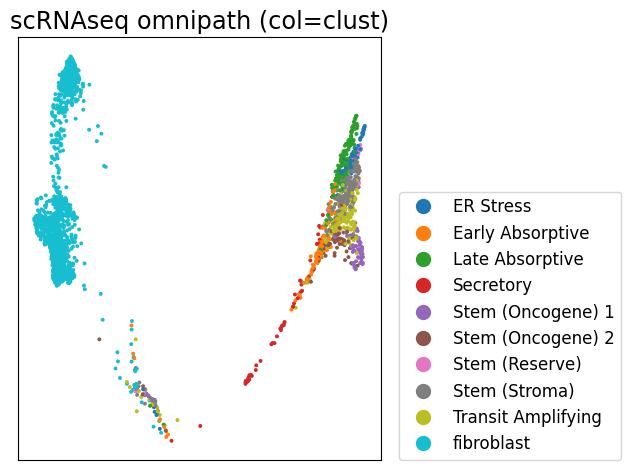

In [101]:
data_phate = phate.PHATE(n_jobs=-2, random_state=12).fit_transform(omnipath_projection) 
scprep.plot.scatter2d(
    data_phate, c=dSEQmd["finalPOPS"],
    title=f"scRNAseq omnipath (col=clust)",
    shuffle=True, ticks=None,
    legend_loc=(1.05, 0))

# Compute intercluster distances

Compute median/mean intercluster distance on GEx knn, customLRT knn, and omnipath knn

In [57]:
dRnaSeq.shape

(3698, 13804)

In [58]:
customLRT_projection.shape

(3698, 10028)

In [59]:
customLRT_PRUNED_projection.shape

(3698, 7116)

In [102]:
omnipath_projection.shape

(3698, 36992)

In [59]:
dSEQmd[["finalPOPS"]].to_dict()

{'finalPOPS': {'WT__AAACCCACAGCTTCCT-1': 'fibroblast',
  'WT__AAACCCAGTTCGAGCC-1': 'fibroblast',
  'WT__AAACGAAAGAAGGATG-1': 'fibroblast',
  'WT__AAACGAAAGGAAAGGT-1': 'Late Absorptive',
  'WT__AAACGAAAGTTAACGA-1': 'Transit Amplifying',
  'WT__AAACGAACACCAGCTG-1': 'fibroblast',
  'WT__AAACGAACACCGTGCA-1': 'fibroblast',
  'WT__AAACGAACATACTTTC-1': 'fibroblast',
  'WT__AAACGCTCACAGCCAC-1': 'fibroblast',
  'WT__AAACGCTCATGACTAC-1': 'fibroblast',
  'WT__AAACGCTGTATCCCAA-1': 'fibroblast',
  'WT__AAACGCTGTCAAGGCA-1': 'fibroblast',
  'WT__AAACGCTGTGATGGCA-1': 'fibroblast',
  'WT__AAACGCTGTTGGCCGT-1': 'fibroblast',
  'WT__AAACGCTTCACCGGGT-1': 'fibroblast',
  'WT__AAAGAACAGCAGCGAT-1': 'Stem (Stroma)',
  'WT__AAAGAACAGGCCCGTT-1': 'fibroblast',
  'WT__AAAGAACCACCAGCCA-1': 'fibroblast',
  'WT__AAAGAACCAGAACATA-1': 'fibroblast',
  'WT__AAAGAACTCTACTGAG-1': 'Stem (Oncogene) 1',
  'WT__AAAGAACTCTGAGATC-1': 'fibroblast',
  'WT__AAAGGATAGAGTCTGG-1': 'fibroblast',
  'WT__AAAGGATAGTGGACTG-1': 'fibroblast'

## Generate cell-cell graphs

In [61]:
from sklearn.decomposition import PCA

cell-cell gex similarity graph

In [62]:
gex_pca = PCA(n_components=100).fit_transform(dRnaSeq)
gex_pca = pd.DataFrame(gex_pca, index=dSEQmd[["finalPOPS"]].index)
gex_pca

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
WT__AAACCCACAGCTTCCT-1,-8.681058,1.338523,-6.630658,-1.752230,-1.215631,0.147127,0.826184,2.024968,-2.591721,-3.455825,...,0.418285,-0.255688,-1.850486,1.750475,-0.934016,0.310456,-0.532895,1.896670,0.374352,1.369889
WT__AAACCCAGTTCGAGCC-1,-9.293916,2.039336,-7.748334,-1.066236,-2.729936,3.802554,0.186004,1.989801,-2.755244,-1.407576,...,-0.215166,0.056485,-0.551942,-0.234643,-1.221376,0.362413,-0.038355,0.539451,-0.625673,0.276638
WT__AAACGAAAGAAGGATG-1,-10.787816,-0.901757,-4.531924,-2.747584,0.574320,-2.737667,2.150524,-2.822483,2.522131,0.570763,...,1.319503,-0.271348,0.916106,-0.539891,-0.821142,-0.624205,0.106061,-0.166635,0.273756,-0.210865
WT__AAACGAAAGGAAAGGT-1,24.187351,-12.197090,-1.349796,6.152577,7.320006,4.441337,6.422537,0.370661,3.238511,1.112564,...,0.911862,0.727421,-0.212633,0.550535,-0.245993,-4.518704,2.802098,-1.507155,-3.190970,-3.981207
WT__AAACGAAAGTTAACGA-1,23.449345,-1.541822,-0.134599,-0.475289,-3.632982,-2.089887,0.157344,-1.730397,-3.746132,0.177288,...,0.249098,0.093136,-0.087025,0.074607,0.159151,0.298316,-0.133400,0.433621,-0.032250,0.346315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,18.828527,-3.209529,0.142557,4.560018,2.153461,-2.745172,0.601529,7.590546,1.861599,-2.082764,...,1.928032,-0.197273,-0.093906,-0.513999,1.426317,-1.324270,2.382546,-1.350669,-0.466979,-1.410538
WT__TTTGGTTTCCGTAGTA-1,-9.910795,-3.005163,-10.007909,0.443212,-1.772006,1.332779,-1.305505,-0.945272,2.769014,0.360136,...,0.144636,0.749348,-1.244383,-0.086025,1.367639,0.074472,1.175034,0.258482,-0.860941,0.846169
WT__TTTGTTGTCGCTTGAA-1,25.732428,-9.265644,-0.074505,3.168175,5.526972,4.306881,4.396309,-1.413062,-1.532841,1.465392,...,-0.046667,-0.200772,0.508197,-0.359283,-0.541640,0.787179,1.130888,-0.511588,0.222910,2.226551
WT__TTTGTTGTCTGAATCG-1,-7.762963,-0.295574,12.570638,-2.733392,-0.140060,1.751047,1.109211,-0.817268,0.446269,-1.088603,...,0.573937,0.165547,0.287081,0.041752,0.367511,-0.779972,-0.221191,-0.329923,0.102335,0.182806


In [63]:
phate_op = phate.PHATE(n_jobs=-2, random_state=12, knn=30, use_pygsp=True)
phate_op.fit(gex_pca)
gex_knn = phate_op.graph
del(phate_op)
gex_knn

Running PHATE on 3698 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.44 seconds.
  Calculating affinities...
  Calculated affinities in 0.10 seconds.
Calculated graph and diffusion operator in 0.77 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.54 seconds.
  Calculating KMeans...
  Calculated KMeans in 4.56 seconds.
Calculated landmark operator in 6.24 seconds.


cell-cell customLRP projection similarity graph

In [64]:
custom_pca = PCA(n_components=100).fit_transform(customLRT_projection)
custom_pca = pd.DataFrame(custom_pca, index=dSEQmd[["finalPOPS"]].index)
custom_pca

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
WT__AAACCCACAGCTTCCT-1,-10.783540,-6.569713,-3.099502,1.175293,-2.881787,-1.207560,1.079283,-3.208005,-1.245908,1.819513,...,-0.189528,-0.596080,-0.812474,-0.854844,-1.627925,1.380382,0.700706,-0.228815,1.468337,1.189639
WT__AAACCCAGTTCGAGCC-1,-9.559621,-9.023865,-5.766150,1.518775,-1.296125,2.456386,2.156774,1.979787,-2.132155,-0.124646,...,-0.071846,-1.981667,0.796867,1.728294,0.376891,-0.458883,-2.167094,-1.426104,-0.401053,1.343498
WT__AAACGAAAGAAGGATG-1,-10.333584,-3.983851,-4.510561,-1.515747,3.846183,0.525800,-5.110784,4.586362,-0.433079,-1.270652,...,1.050008,-0.843295,-0.807557,-1.630357,-0.838140,0.856711,-0.581260,-1.299371,-0.676101,-0.705802
WT__AAACGAAAGGAAAGGT-1,23.745192,15.152277,-8.415726,3.368756,12.023341,-1.258961,1.382099,-0.381549,-1.024233,2.435571,...,2.817391,-1.528677,-1.610405,3.346499,-1.170719,-4.129766,0.048012,1.393911,-0.823775,0.078532
WT__AAACGAAAGTTAACGA-1,21.557772,-0.187541,-0.806595,-0.374148,-3.964228,-1.728849,-1.089169,-0.203515,1.065599,-2.562735,...,0.127514,-0.351317,-0.399616,-0.050149,-0.843870,-0.929615,0.436461,0.445253,-0.740054,-0.406178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,18.536201,-1.223958,-2.464071,-2.787009,3.230859,-2.697552,-0.075251,2.322884,-3.885566,4.958494,...,1.267702,-0.063917,1.194259,2.658873,1.475250,0.436167,-0.959238,-0.429508,-0.670015,0.324649
WT__TTTGGTTTCCGTAGTA-1,-11.117522,-5.015599,-9.433123,-0.703030,-0.331615,0.059965,-2.245792,4.285832,-1.619120,0.617058,...,0.068875,1.281095,-1.252026,-0.152943,-0.196046,-0.616547,0.331269,-1.380902,-1.727057,0.704094
WT__TTTGTTGTCGCTTGAA-1,25.450797,11.301941,-3.141283,2.950701,3.677734,2.121606,2.030696,-0.587854,-1.786883,-1.706746,...,-0.494615,0.530786,0.997635,0.241312,-1.331952,-0.081618,-0.842290,-0.449998,-0.885407,0.995577
WT__TTTGTTGTCTGAATCG-1,-4.969585,8.824941,10.192317,-5.899414,-0.476227,0.918021,1.063294,3.722206,-1.056371,-1.174006,...,-0.600950,-0.078175,0.408426,-0.294637,-0.789023,-0.276492,0.649652,0.479050,-0.042437,-0.017184


In [65]:
phate_op = phate.PHATE(n_jobs=-2, random_state=12, knn=30, use_pygsp=True)
phate_op.fit(custom_pca)
custom_knn = phate_op.graph
del(phate_op)
custom_knn

Running PHATE on 3698 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.46 seconds.
  Calculating affinities...
  Calculated affinities in 0.08 seconds.
Calculated graph and diffusion operator in 0.81 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.58 seconds.
  Calculating KMeans...
  Calculated KMeans in 5.30 seconds.
Calculated landmark operator in 7.09 seconds.


In [70]:
#Custom pruned graph
custom_PRUNED_pca = PCA(n_components=100).fit_transform(customLRT_PRUNED_projection)
custom_PRUNED_pca = pd.DataFrame(custom_PRUNED_pca, index=dSEQmd[["finalPOPS"]].index)
custom_PRUNED_pca

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
WT__AAACCCACAGCTTCCT-1,-9.605517,-4.137467,-3.330675,1.626507,-2.939568,-0.625253,-0.525048,-1.702469,1.655888,0.338580,...,0.240409,0.053896,1.069098,0.545563,-0.688524,-1.636576,0.995645,-1.427182,0.513545,0.155264
WT__AAACCCAGTTCGAGCC-1,-9.133786,-5.667594,-6.306636,2.551135,-2.532033,1.885504,1.045315,3.398088,0.194046,0.554011,...,-0.443309,0.196939,2.048345,0.353987,0.063788,0.751472,1.137979,0.851553,0.944196,0.455048
WT__AAACGAAAGAAGGATG-1,-9.077095,0.374457,-7.895284,-0.700402,3.838883,0.652877,-2.163423,4.339196,-1.162799,-1.132953,...,-0.921541,1.108004,-0.471091,-1.629063,-1.527915,1.410786,1.341127,-1.233385,0.694851,0.469265
WT__AAACGAAAGGAAAGGT-1,24.638112,17.982995,-5.755497,2.770049,8.685947,-2.377840,4.073569,0.756749,2.333192,0.890254,...,-0.964991,-1.597497,0.741795,-1.176618,-1.131739,-1.773851,-0.554291,-0.697339,-0.118595,-1.451601
WT__AAACGAAAGTTAACGA-1,18.756821,0.088299,-0.614438,-0.673107,-2.198041,-1.697063,-1.872072,-0.979625,-3.192763,-0.685521,...,-1.820873,0.171155,-1.079603,-0.317184,0.453419,-0.092021,0.007325,0.346766,0.619918,-0.574583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,16.667747,-1.696627,-4.295644,-2.659644,1.430081,-2.211672,1.054963,3.351712,5.480125,1.521749,...,-1.910746,0.876916,0.785522,-0.450109,0.605062,0.768102,-1.661339,0.342110,0.529020,0.258192
WT__TTTGGTTTCCGTAGTA-1,-8.842029,0.005704,-9.982395,1.073909,-0.595175,0.084258,-1.735257,3.483297,-2.376259,1.860532,...,2.107625,2.105387,-1.369036,0.953808,0.689894,0.339731,0.010466,-1.520665,0.966039,-0.395161
WT__TTTGTTGTCGCTTGAA-1,23.017744,10.947214,2.063779,3.138864,1.106850,1.808048,3.683006,0.808325,1.460721,-2.768166,...,0.830347,-2.048124,0.297646,-0.154304,-0.679566,-0.032757,-0.849624,0.165950,1.918009,-1.715081
WT__TTTGTTGTCTGAATCG-1,-4.584962,3.686330,10.353438,-7.056557,-0.845054,-0.524489,1.457738,3.100705,0.048209,-0.835815,...,0.030844,-0.436635,0.866862,-0.226006,-0.127363,-1.116549,1.616054,0.873404,-0.859120,0.218026


In [71]:
phate_op = phate.PHATE(n_jobs=-2, random_state=12, knn=30, use_pygsp=True)
phate_op.fit(custom_PRUNED_pca)
custom__PRUNED_knn = phate_op.graph
del(phate_op)
custom__PRUNED_knn

Running PHATE on 3698 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.47 seconds.
  Calculating affinities...
  Calculated affinities in 0.08 seconds.
Calculated graph and diffusion operator in 0.80 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.68 seconds.
  Calculating KMeans...
  Calculated KMeans in 5.38 seconds.
Calculated landmark operator in 7.39 seconds.


cell-cell omnipath projection similarity graph

In [103]:
omni_pca = PCA(n_components=100).fit_transform(omnipath_projection)
omni_pca = pd.DataFrame(omni_pca, index=dSEQmd[["finalPOPS"]].index)
omni_pca

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
WT__AAACCCACAGCTTCCT-1,-14.041148,-2.049595,-11.380233,-1.034806,2.418315,0.878277,3.403810,5.390663,-5.136441,-0.042666,...,0.062068,-1.792433,-0.872895,-2.664336,-0.183917,0.827318,-0.757670,-2.225098,-3.215641,-0.492622
WT__AAACCCAGTTCGAGCC-1,-14.474821,-1.245357,-12.735080,1.724171,7.848254,4.079719,2.077282,2.145226,-3.577298,0.241201,...,1.136579,-0.525193,1.051200,0.266983,-0.751905,-0.642718,-0.315094,1.268782,-0.092122,-1.009176
WT__AAACGAAAGAAGGATG-1,-16.208897,-5.121582,-9.093654,-5.067165,-1.576843,-3.904317,1.179680,-6.144872,1.331855,3.649389,...,-2.005510,-0.656800,0.772009,-0.050913,-1.705260,0.530961,1.024898,0.289907,-0.269241,0.429249
WT__AAACGAAAGGAAAGGT-1,36.157150,-16.397057,4.926048,5.816417,-9.546974,7.516048,10.842181,-2.932556,3.422561,2.381266,...,-3.939477,1.441652,-2.559389,-1.822919,5.319200,-2.263364,3.212405,6.035310,0.915735,3.071104
WT__AAACGAAAGTTAACGA-1,38.102404,-3.075776,1.261708,-0.680022,4.092406,-5.531542,0.256235,-0.210881,-1.759245,-4.883852,...,1.061341,-0.450394,0.786535,-0.358646,-0.051556,-0.125675,0.887681,-0.894574,0.119781,0.074346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,31.114182,-5.538694,1.701614,3.045914,-7.381345,2.088974,4.177536,8.449472,1.586653,6.409748,...,0.576101,-0.050535,-0.196732,-1.689119,0.342135,-1.368625,0.778199,0.005427,0.702453,2.134839
WT__TTTGGTTTCCGTAGTA-1,-17.309963,-8.909058,-10.971230,2.807290,4.678790,-0.394955,-1.916891,-4.043565,0.817036,4.695931,...,-0.666902,-0.682868,1.045579,-1.514779,0.804478,2.260900,-0.374538,-3.077039,-0.700855,0.606901
WT__TTTGTTGTCGCTTGAA-1,39.063041,-11.230576,5.669273,7.536846,-3.318633,8.012555,6.883172,-5.422222,2.682185,-0.190062,...,1.968350,1.083128,1.699043,-1.909739,-1.909244,-0.367982,1.151641,0.800769,-2.102742,0.078348
WT__TTTGTTGTCTGAATCG-1,-12.517474,7.834114,19.643426,-7.293731,1.387043,1.237356,1.977470,-2.470248,-1.135715,-0.032089,...,0.043582,-1.053136,1.324862,0.363368,-0.444731,-0.219163,0.082013,-1.022623,0.107931,1.082077


In [104]:
phate_op = phate.PHATE(n_jobs=-2, random_state=12, knn=30, use_pygsp=True)
phate_op.fit(omni_pca)
omni_knn = phate_op.graph
del(phate_op)
omni_knn

Running PHATE on 3698 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...


  Calculated KNN search in 0.47 seconds.
  Calculating affinities...
  Calculated affinities in 0.08 seconds.
Calculated graph and diffusion operator in 0.77 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.63 seconds.
  Calculating KMeans...
  Calculated KMeans in 4.31 seconds.
Calculated landmark operator in 6.10 seconds.


In [67]:
gex_knn
custom_knn
omni_knn

## Compute distances to/from all cells

In [67]:
gex_dist = pd.DataFrame(gex_knn.shortest_path(), index=dSEQmd.index, columns=dSEQmd.index)
gex_dist

Using negative log affinity distances.


,WT__AAACCCACAGCTTCCT-1,WT__AAACCCAGTTCGAGCC-1,WT__AAACGAAAGAAGGATG-1,WT__AAACGAAAGGAAAGGT-1,WT__AAACGAAAGTTAACGA-1,WT__AAACGAACACCAGCTG-1,WT__AAACGAACACCGTGCA-1,WT__AAACGAACATACTTTC-1,WT__AAACGCTCACAGCCAC-1,WT__AAACGCTCATGACTAC-1,...,WT__TTTGATCGTGTTAGCT-1,WT__TTTGATCTCTCATGGA-1,WT__TTTGGAGCAACGCCCA-1,WT__TTTGGAGGTACCATAC-1,WT__TTTGGTTAGCGGGTAT-1,WT__TTTGGTTTCATTCTTG-1,WT__TTTGGTTTCCGTAGTA-1,WT__TTTGTTGTCGCTTGAA-1,WT__TTTGTTGTCTGAATCG-1,WT__TTTGTTGTCTGGGTCG-1
WT__AAACCCACAGCTTCCT-1,0.000000,0.706048,0.724258,1.624766,0.931527,0.707555,0.738978,0.721370,0.717869,1.460156,...,0.791251,0.931366,1.456116,1.414570,0.781572,0.931461,0.724006,0.976010,0.709366,0.931298
WT__AAACCCAGTTCGAGCC-1,0.706048,0.000000,0.019882,0.920390,0.227151,0.003179,0.038657,0.021049,0.013493,0.755827,...,0.086875,0.226989,0.755795,0.713027,0.077242,0.227085,0.023685,0.271634,0.004990,0.226922
WT__AAACGAAAGAAGGATG-1,0.724258,0.019882,0.000000,0.936340,0.243102,0.019130,0.054828,0.037142,0.029444,0.771778,...,0.102825,0.242940,0.772430,0.726662,0.093193,0.243036,0.037461,0.287585,0.020940,0.242872
WT__AAACGAAAGGAAAGGT-1,1.624766,0.920390,0.936340,0.000000,0.693542,0.917305,0.957374,0.939766,0.926645,1.669313,...,1.000361,0.693444,1.674512,1.626514,0.990729,0.693756,0.942402,0.738267,0.918142,0.693556
WT__AAACGAAAGTTAACGA-1,0.931527,0.227151,0.243102,0.693542,0.000000,0.224067,0.264136,0.246528,0.233407,0.976075,...,0.307123,0.000268,0.981274,0.933275,0.297490,0.000581,0.249164,0.045090,0.224903,0.000242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.931461,0.227085,0.243036,0.693756,0.000581,0.224000,0.264069,0.246461,0.233341,0.976009,...,0.307057,0.000407,0.981208,0.933209,0.297424,0.000000,0.249097,0.045027,0.224837,0.000570
WT__TTTGGTTTCCGTAGTA-1,0.724006,0.023685,0.037461,0.942402,0.249164,0.025191,0.046042,0.028356,0.035506,0.771586,...,0.108887,0.249002,0.765516,0.719793,0.095963,0.249097,0.000000,0.293646,0.027002,0.248934
WT__TTTGTTGTCGCTTGAA-1,0.976010,0.271634,0.287585,0.738267,0.045090,0.268549,0.308618,0.291010,0.277890,1.020558,...,0.351606,0.044971,1.025757,0.977758,0.341973,0.045027,0.293646,0.000000,0.269386,0.045105
WT__TTTGTTGTCTGAATCG-1,0.709366,0.004990,0.020940,0.918142,0.224903,0.001905,0.041974,0.024366,0.011093,0.753925,...,0.084973,0.224742,0.759112,0.711126,0.075340,0.224837,0.027002,0.269386,0.000000,0.224674


In [68]:
custom_dist = pd.DataFrame(custom_knn.shortest_path(), index=dSEQmd.index, columns=dSEQmd.index)
custom_dist

Using negative log affinity distances.


,WT__AAACCCACAGCTTCCT-1,WT__AAACCCAGTTCGAGCC-1,WT__AAACGAAAGAAGGATG-1,WT__AAACGAAAGGAAAGGT-1,WT__AAACGAAAGTTAACGA-1,WT__AAACGAACACCAGCTG-1,WT__AAACGAACACCGTGCA-1,WT__AAACGAACATACTTTC-1,WT__AAACGCTCACAGCCAC-1,WT__AAACGCTCATGACTAC-1,...,WT__TTTGATCGTGTTAGCT-1,WT__TTTGATCTCTCATGGA-1,WT__TTTGGAGCAACGCCCA-1,WT__TTTGGAGGTACCATAC-1,WT__TTTGGTTAGCGGGTAT-1,WT__TTTGGTTTCATTCTTG-1,WT__TTTGGTTTCCGTAGTA-1,WT__TTTGTTGTCGCTTGAA-1,WT__TTTGTTGTCTGAATCG-1,WT__TTTGTTGTCTGGGTCG-1
WT__AAACCCACAGCTTCCT-1,0.000000,0.732890,0.890833,1.892235,1.196744,0.696176,1.026276,0.667898,0.731145,1.364300,...,0.931150,1.198873,1.428550,1.436913,1.400121,1.203286,0.766054,1.210935,0.710363,1.198503
WT__AAACCCAGTTCGAGCC-1,0.732890,0.000000,0.276789,1.256250,0.560759,0.038423,0.427256,0.069678,0.074094,0.775005,...,0.325854,0.562888,0.819435,0.799371,0.757082,0.567301,0.133861,0.574950,0.056463,0.562518
WT__AAACGAAAGAAGGATG-1,0.890833,0.276789,0.000000,1.441468,0.745976,0.239794,0.582290,0.242036,0.275622,0.937949,...,0.498902,0.748106,0.969639,0.981235,0.924119,0.752519,0.296542,0.760167,0.257873,0.747735
WT__AAACGAAAGGAAAGGT-1,1.892235,1.256250,1.441468,0.000000,0.695492,1.219537,1.586602,1.229024,1.254505,1.947294,...,1.500436,0.696794,1.994453,1.978529,1.923779,0.700152,1.296497,0.706189,1.233724,0.697002
WT__AAACGAAAGTTAACGA-1,1.196744,0.560759,0.745976,0.695492,0.000000,0.524045,0.891110,0.533532,0.559014,1.251802,...,0.804945,0.002130,1.298962,1.283038,1.228288,0.006598,0.601006,0.014191,0.538232,0.001923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,1.203286,0.567301,0.752519,0.700152,0.006598,0.530588,0.897653,0.540075,0.565556,1.258345,...,0.811487,0.008728,1.305504,1.289580,1.234830,0.000000,0.607548,0.018852,0.544775,0.008430
WT__TTTGGTTTCCGTAGTA-1,0.766054,0.133861,0.296542,1.296497,0.601006,0.096865,0.447565,0.109768,0.132693,0.806614,...,0.372888,0.603135,0.849528,0.849900,0.786973,0.607548,0.000000,0.615197,0.112902,0.602765
WT__TTTGTTGTCGCTTGAA-1,1.210935,0.574950,0.760167,0.706189,0.014191,0.538237,0.905301,0.547724,0.573205,1.265994,...,0.819136,0.015493,1.313153,1.297229,1.242479,0.018852,0.615197,0.000000,0.552424,0.015702
WT__TTTGTTGTCTGAATCG-1,0.710363,0.056463,0.257873,1.233724,0.538232,0.019622,0.404730,0.047152,0.022641,0.753679,...,0.302866,0.540362,0.798108,0.778045,0.738283,0.544775,0.112902,0.552424,0.000000,0.539991


In [72]:
custom_PRUNED_dist = pd.DataFrame(custom__PRUNED_knn.shortest_path(), index=dSEQmd.index, columns=dSEQmd.index)
custom_PRUNED_dist

Using negative log affinity distances.


,WT__AAACCCACAGCTTCCT-1,WT__AAACCCAGTTCGAGCC-1,WT__AAACGAAAGAAGGATG-1,WT__AAACGAAAGGAAAGGT-1,WT__AAACGAAAGTTAACGA-1,WT__AAACGAACACCAGCTG-1,WT__AAACGAACACCGTGCA-1,WT__AAACGAACATACTTTC-1,WT__AAACGCTCACAGCCAC-1,WT__AAACGCTCATGACTAC-1,...,WT__TTTGATCGTGTTAGCT-1,WT__TTTGATCTCTCATGGA-1,WT__TTTGGAGCAACGCCCA-1,WT__TTTGGAGGTACCATAC-1,WT__TTTGGTTAGCGGGTAT-1,WT__TTTGGTTTCATTCTTG-1,WT__TTTGGTTTCCGTAGTA-1,WT__TTTGTTGTCGCTTGAA-1,WT__TTTGTTGTCTGAATCG-1,WT__TTTGTTGTCTGGGTCG-1
WT__AAACCCACAGCTTCCT-1,0.000000,0.459385,0.698569,1.363257,0.659321,0.439130,0.535313,0.441059,0.479101,1.121389,...,1.041762,0.678241,1.008335,1.229570,0.665818,0.683955,0.498045,0.697774,0.450960,0.662713
WT__AAACCCAGTTCGAGCC-1,0.459385,0.000000,0.306227,0.953472,0.249537,0.020271,0.199728,0.090398,0.066200,0.780577,...,0.683418,0.268457,0.660478,0.888758,0.288402,0.274170,0.129311,0.287989,0.038060,0.252928
WT__AAACGAAAGAAGGATG-1,0.698569,0.306227,0.000000,1.213163,0.509227,0.285971,0.445982,0.343198,0.327641,1.027121,...,0.943392,0.528147,0.907022,1.135303,0.547806,0.533861,0.379208,0.547680,0.299500,0.512619
WT__AAACGAAAGGAAAGGT-1,1.363257,0.953472,1.213163,0.000000,0.705343,0.933217,1.103600,0.994270,0.962351,1.684449,...,1.590406,0.727220,1.564350,1.792630,1.192274,0.732933,1.033183,0.731962,0.942760,0.710901
WT__AAACGAAAGTTAACGA-1,0.659321,0.249537,0.509227,0.705343,0.000000,0.229281,0.399665,0.290335,0.258416,0.980513,...,0.886470,0.021877,0.860414,1.088694,0.488338,0.028292,0.329247,0.039860,0.238825,0.005736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.683955,0.274170,0.533861,0.732933,0.028292,0.253914,0.424298,0.314968,0.283049,1.005146,...,0.911103,0.049844,0.885047,1.113327,0.512971,0.000000,0.353880,0.067450,0.263458,0.033810
WT__TTTGGTTTCCGTAGTA-1,0.498045,0.129311,0.379208,1.033183,0.329247,0.109055,0.238388,0.123673,0.149026,0.819236,...,0.733281,0.348167,0.699137,0.927418,0.291105,0.353880,0.000000,0.367700,0.120886,0.332638
WT__TTTGTTGTCGCTTGAA-1,0.697774,0.287989,0.547680,0.731962,0.039860,0.267734,0.438117,0.328787,0.296868,1.018966,...,0.924923,0.061737,0.898867,1.127147,0.526791,0.067450,0.367700,0.000000,0.277277,0.045418
WT__TTTGTTGTCTGAATCG-1,0.450960,0.038060,0.299500,0.942760,0.238825,0.017804,0.191303,0.081973,0.041359,0.772152,...,0.671774,0.257745,0.652053,0.880333,0.279977,0.263458,0.120886,0.277277,0.000000,0.242216


In [105]:
omni_dist = pd.DataFrame(omni_knn.shortest_path(), index=dSEQmd.index, columns=dSEQmd.index)
omni_dist

Using negative log affinity distances.


,WT__AAACCCACAGCTTCCT-1,WT__AAACCCAGTTCGAGCC-1,WT__AAACGAAAGAAGGATG-1,WT__AAACGAAAGGAAAGGT-1,WT__AAACGAAAGTTAACGA-1,WT__AAACGAACACCAGCTG-1,WT__AAACGAACACCGTGCA-1,WT__AAACGAACATACTTTC-1,WT__AAACGCTCACAGCCAC-1,WT__AAACGCTCATGACTAC-1,...,WT__TTTGATCGTGTTAGCT-1,WT__TTTGATCTCTCATGGA-1,WT__TTTGGAGCAACGCCCA-1,WT__TTTGGAGGTACCATAC-1,WT__TTTGGTTAGCGGGTAT-1,WT__TTTGGTTTCATTCTTG-1,WT__TTTGGTTTCCGTAGTA-1,WT__TTTGTTGTCGCTTGAA-1,WT__TTTGTTGTCTGAATCG-1,WT__TTTGTTGTCTGGGTCG-1
WT__AAACCCACAGCTTCCT-1,0.000000,0.777888,0.781707,1.866131,1.170380,0.714014,0.748283,0.741779,0.729443,1.483193,...,0.790799,1.169884,0.982099,1.413718,0.828398,1.171210,0.726677,1.187347,0.715787,1.170373
WT__AAACCCAGTTCGAGCC-1,0.777888,0.000000,0.140750,1.218044,0.522293,0.065421,0.110895,0.099767,0.081356,0.836173,...,0.150346,0.521797,0.342512,0.774131,0.189029,0.523122,0.085720,0.539260,0.067703,0.522286
WT__AAACGAAAGAAGGATG-1,0.781707,0.140750,0.000000,1.228009,0.532258,0.075892,0.099362,0.102428,0.091321,0.846138,...,0.133718,0.531762,0.345346,0.776966,0.174872,0.533087,0.069523,0.549225,0.077665,0.532250
WT__AAACGAAAGGAAAGGT-1,1.866131,1.218044,1.228009,0.000000,0.696057,1.152623,1.196860,1.185732,1.167452,1.922138,...,1.236971,0.696258,1.429771,1.861390,1.274994,0.697515,1.172979,0.713400,1.153796,0.696092
WT__AAACGAAAGTTAACGA-1,1.170380,0.522293,0.532258,0.696057,0.000000,0.456872,0.501109,0.489981,0.471701,1.226387,...,0.541219,0.000507,0.734020,1.165639,0.579243,0.001922,0.477228,0.017648,0.458045,0.000340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,1.171210,0.523122,0.533087,0.697515,0.001922,0.457701,0.501939,0.490811,0.472530,1.227217,...,0.542049,0.001426,0.734849,1.166468,0.580073,0.000000,0.478057,0.016237,0.458874,0.001915
WT__TTTGGTTTCCGTAGTA-1,0.726677,0.085720,0.069523,1.172979,0.477228,0.020862,0.049267,0.049862,0.036291,0.791108,...,0.093377,0.476732,0.290316,0.721936,0.125881,0.478057,0.000000,0.494195,0.022635,0.477221
WT__TTTGTTGTCGCTTGAA-1,1.187347,0.539260,0.549225,0.713400,0.017648,0.473839,0.518076,0.506948,0.488668,1.243354,...,0.558187,0.017564,0.750987,1.182606,0.596210,0.016237,0.494195,0.000000,0.475012,0.017633
WT__TTTGTTGTCTGAATCG-1,0.715787,0.067703,0.077665,1.153796,0.458045,0.002282,0.046297,0.035169,0.015536,0.771575,...,0.086514,0.457549,0.279427,0.711046,0.124431,0.458874,0.022635,0.475012,0.000000,0.458037


## View distances

In [73]:
clusters = sorted(set(dSEQmd["finalPOPS"].to_dict().values()))

In [74]:
new_matrix = np.zeros((len(clusters), len(clusters)))

for i, group_i in enumerate(clusters):
    for j, group_j in enumerate(clusters):
        if i != j:
            group_i_indices = [k for k, v in dSEQmd["finalPOPS"].to_dict().items() if v == group_i]
            group_j_indices = [k for k, v in dSEQmd["finalPOPS"].to_dict().items() if v == group_j]
            submatrix = gex_dist.loc[group_i_indices, group_j_indices]
            mean_distance = submatrix.mean().mean()
            new_matrix[i, j] = mean_distance

gex_matrix = pd.DataFrame(index=clusters, columns=clusters, data=new_matrix)
gex_matrix.style.background_gradient(cmap="inferno", axis=None)

,ER Stress,Early Absorptive,Late Absorptive,Secretory,Stem (Oncogene) 1,Stem (Oncogene) 2,Stem (Reserve),Stem (Stroma),Transit Amplifying,fibroblast
ER Stress,0.000000,0.062204,0.039315,0.074032,0.068639,0.064966,0.208466,0.058161,0.089588,0.312952
Early Absorptive,0.062204,0.000000,0.053141,0.087691,0.082929,0.079186,0.223905,0.072271,0.103672,0.332483
Late Absorptive,0.039315,0.053141,0.000000,0.063642,0.060671,0.056724,0.204412,0.049278,0.080879,0.324817
Secretory,0.074032,0.087691,0.063642,0.000000,0.095580,0.091531,0.240716,0.083875,0.115502,0.366141
Stem (Oncogene) 1,0.068639,0.082929,0.060671,0.095580,0.000000,0.084987,0.226122,0.078717,0.109915,0.320476
Stem (Oncogene) 2,0.064966,0.079186,0.056724,0.091531,0.084987,0.000000,0.223520,0.075059,0.106313,0.321486
Stem (Reserve),0.208466,0.223905,0.204412,0.240716,0.226122,0.223520,0.000000,0.219067,0.249579,0.395935
Stem (Stroma),0.058161,0.072271,0.049278,0.083875,0.078717,0.075059,0.219067,0.000000,0.099572,0.326207
Transit Amplifying,0.089588,0.103672,0.080879,0.115502,0.109915,0.106313,0.249579,0.099572,0.000000,0.353790
fibroblast,0.312952,0.332483,0.324817,0.366141,0.320476,0.321486,0.395935,0.326207,0.353790,0.000000


In [75]:
new_matrix = np.zeros((len(clusters), len(clusters)))

for i, group_i in enumerate(clusters):
    for j, group_j in enumerate(clusters):
        if i != j:
            group_i_indices = [k for k, v in dSEQmd["finalPOPS"].to_dict().items() if v == group_i]
            group_j_indices = [k for k, v in dSEQmd["finalPOPS"].to_dict().items() if v == group_j]
            submatrix = custom_dist.loc[group_i_indices, group_j_indices]
            mean_distance = submatrix.mean().mean()
            new_matrix[i, j] = mean_distance

custom_matrix = pd.DataFrame(index=clusters, columns=clusters, data=new_matrix)
custom_matrix.style.background_gradient(cmap="inferno", axis=None)

,ER Stress,Early Absorptive,Late Absorptive,Secretory,Stem (Oncogene) 1,Stem (Oncogene) 2,Stem (Reserve),Stem (Stroma),Transit Amplifying,fibroblast
ER Stress,0.000000,0.174751,0.114697,0.114181,0.166124,0.180348,0.539798,0.159738,0.227708,0.678794
Early Absorptive,0.174751,0.000000,0.123775,0.122052,0.176389,0.190099,0.555557,0.170162,0.237415,0.702064
Late Absorptive,0.114697,0.123775,0.000000,0.059392,0.118356,0.131757,0.504540,0.110166,0.178019,0.681124
Secretory,0.114181,0.122052,0.059392,0.000000,0.118514,0.131311,0.507462,0.109470,0.177403,0.695754
Stem (Oncogene) 1,0.166124,0.176389,0.118356,0.118514,0.000000,0.178629,0.535641,0.160720,0.227308,0.645366
Stem (Oncogene) 2,0.180348,0.190099,0.131757,0.131311,0.178629,0.000000,0.552748,0.175193,0.241905,0.671411
Stem (Reserve),0.539798,0.555557,0.504540,0.507462,0.535641,0.552748,0.000000,0.537314,0.602467,0.854789
Stem (Stroma),0.159738,0.170162,0.110166,0.109470,0.160720,0.175193,0.537314,0.000000,0.222084,0.682230
Transit Amplifying,0.227708,0.237415,0.178019,0.177403,0.227308,0.241905,0.602467,0.222084,0.000000,0.739006
fibroblast,0.678794,0.702064,0.681124,0.695754,0.645366,0.671411,0.854789,0.682230,0.739006,0.000000


In [76]:
new_matrix = np.zeros((len(clusters), len(clusters)))

for i, group_i in enumerate(clusters):
    for j, group_j in enumerate(clusters):
        if i != j:
            group_i_indices = [k for k, v in dSEQmd["finalPOPS"].to_dict().items() if v == group_i]
            group_j_indices = [k for k, v in dSEQmd["finalPOPS"].to_dict().items() if v == group_j]
            submatrix = custom_PRUNED_dist.loc[group_i_indices, group_j_indices]
            mean_distance = submatrix.mean().mean()
            new_matrix[i, j] = mean_distance

custom_PRUNED_matrix = pd.DataFrame(index=clusters, columns=clusters, data=new_matrix)
custom_PRUNED_matrix.style.background_gradient(cmap="inferno", axis=None)

,ER Stress,Early Absorptive,Late Absorptive,Secretory,Stem (Oncogene) 1,Stem (Oncogene) 2,Stem (Reserve),Stem (Stroma),Transit Amplifying,fibroblast
ER Stress,0.000000,0.157277,0.103274,0.116187,0.157970,0.161748,0.462470,0.139057,0.196615,0.424021
Early Absorptive,0.157277,0.000000,0.126085,0.137353,0.181511,0.184541,0.489713,0.163106,0.219476,0.456146
Late Absorptive,0.103274,0.126085,0.000000,0.079574,0.129880,0.132972,0.438664,0.109562,0.166763,0.419320
Secretory,0.116187,0.137353,0.079574,0.000000,0.142768,0.145510,0.452282,0.122071,0.179061,0.432579
Stem (Oncogene) 1,0.157970,0.181511,0.129880,0.142768,0.000000,0.181509,0.486277,0.162491,0.218669,0.437396
Stem (Oncogene) 2,0.161748,0.184541,0.132972,0.145510,0.181509,0.000000,0.491014,0.166488,0.222699,0.445779
Stem (Reserve),0.462470,0.489713,0.438664,0.452282,0.486277,0.491014,0.000000,0.469391,0.525985,0.675606
Stem (Stroma),0.139057,0.163106,0.109562,0.122071,0.162491,0.166488,0.469391,0.000000,0.201394,0.435509
Transit Amplifying,0.196615,0.219476,0.166763,0.179061,0.218669,0.222699,0.525985,0.201394,0.000000,0.489018
fibroblast,0.424021,0.456146,0.419320,0.432579,0.437396,0.445779,0.675606,0.435509,0.489018,0.000000


In [106]:
new_matrix = np.zeros((len(clusters), len(clusters)))

for i, group_i in enumerate(clusters):
    for j, group_j in enumerate(clusters):
        if i != j:
            group_i_indices = [k for k, v in dSEQmd["finalPOPS"].to_dict().items() if v == group_i]
            group_j_indices = [k for k, v in dSEQmd["finalPOPS"].to_dict().items() if v == group_j]
            submatrix = omni_dist.loc[group_i_indices, group_j_indices]
            mean_distance = submatrix.mean().mean()
            new_matrix[i, j] = mean_distance

omni_matrix = pd.DataFrame(index=clusters, columns=clusters, data=new_matrix)
omni_matrix.style.background_gradient(cmap="inferno", axis=None)

,ER Stress,Early Absorptive,Late Absorptive,Secretory,Stem (Oncogene) 1,Stem (Oncogene) 2,Stem (Reserve),Stem (Stroma),Transit Amplifying,fibroblast
ER Stress,0.000000,0.096915,0.062506,0.106527,0.128989,0.114516,0.337353,0.101828,0.127157,0.532832
Early Absorptive,0.096915,0.000000,0.071422,0.115105,0.138872,0.124230,0.349985,0.111353,0.136670,0.554439
Late Absorptive,0.062506,0.071422,0.000000,0.078478,0.105748,0.090700,0.323259,0.076587,0.102364,0.554820
Secretory,0.106527,0.115105,0.078478,0.000000,0.150149,0.134921,0.369339,0.120492,0.146355,0.606582
Stem (Oncogene) 1,0.128989,0.138872,0.105748,0.150149,0.000000,0.154793,0.372291,0.143490,0.168307,0.544925
Stem (Oncogene) 2,0.114516,0.124230,0.090700,0.134921,0.154793,0.000000,0.360280,0.128978,0.153928,0.540950
Stem (Reserve),0.337353,0.349985,0.323259,0.369339,0.372291,0.360280,0.000000,0.353014,0.376477,0.606411
Stem (Stroma),0.101828,0.111353,0.076587,0.120492,0.143490,0.128978,0.353014,0.000000,0.141379,0.554951
Transit Amplifying,0.127157,0.136670,0.102364,0.146355,0.168307,0.153928,0.376477,0.141379,0.000000,0.571174
fibroblast,0.532832,0.554439,0.554820,0.606582,0.544925,0.540950,0.606411,0.554951,0.571174,0.000000


Compare projections

In [98]:
from sklearn.preprocessing import minmax_scale

scaled_gex = pd.DataFrame(data = minmax_scale(gex_matrix.values.flatten(),feature_range=(0,1)).reshape(gex_matrix.values.shape), index=clusters, columns=clusters)
scaled_gex.style.background_gradient(cmap="inferno", axis=None)

,ER Stress,Early Absorptive,Late Absorptive,Secretory,Stem (Oncogene) 1,Stem (Oncogene) 2,Stem (Reserve),Stem (Stroma),Transit Amplifying,fibroblast
ER Stress,0.000000,0.134136,0.087232,0.144213,0.161209,0.154001,0.553933,0.129671,0.187844,0.759904
Early Absorptive,0.134136,0.000000,0.110047,0.166665,0.185258,0.177877,0.580909,0.153192,0.211384,0.797288
Late Absorptive,0.087232,0.110047,0.000000,0.116684,0.139993,0.132073,0.543032,0.106004,0.164687,0.790359
Secretory,0.144213,0.166665,0.116684,0.000000,0.197554,0.189356,0.604088,0.162743,0.221462,0.864652
Stem (Oncogene) 1,0.161209,0.185258,0.139993,0.197554,0.000000,0.203334,0.596904,0.180319,0.237957,0.776085
Stem (Oncogene) 2,0.154001,0.177877,0.132073,0.189356,0.203334,0.000000,0.592524,0.173165,0.230962,0.781164
Stem (Reserve),0.553933,0.580909,0.543032,0.604088,0.596904,0.592524,0.000000,0.573983,0.630285,1.000000
Stem (Stroma),0.129671,0.153192,0.106004,0.162743,0.180319,0.173165,0.573983,0.000000,0.206725,0.787210
Transit Amplifying,0.187844,0.211384,0.164687,0.221462,0.237957,0.230962,0.630285,0.206725,0.000000,0.835137
fibroblast,0.759904,0.797288,0.790359,0.864652,0.776085,0.781164,1.000000,0.787210,0.835137,0.000000


In [103]:
scaled_gex.style.background_gradient(cmap="inferno", axis=None).to_latex(buf="test.txt", convert_css=True)

In [97]:
scaled_LRT = pd.DataFrame(data = minmax_scale(custom_matrix.values.flatten(),feature_range=(0,1)).reshape(custom_matrix.values.shape), index=clusters, columns=clusters)
scaled_LRT.style.background_gradient(cmap="inferno", axis=None)

,ER Stress,Early Absorptive,Late Absorptive,Secretory,Stem (Oncogene) 1,Stem (Oncogene) 2,Stem (Reserve),Stem (Stroma),Transit Amplifying,fibroblast
ER Stress,0.000000,0.215563,0.145190,0.139818,0.201897,0.218083,0.632105,0.198838,0.277580,0.803968
Early Absorptive,0.215563,0.000000,0.153977,0.147012,0.211975,0.227420,0.647468,0.209010,0.287032,0.828309
Late Absorptive,0.145190,0.153977,0.000000,0.074063,0.143724,0.159109,0.587539,0.138559,0.217404,0.802999
Secretory,0.139818,0.147012,0.074063,0.000000,0.138364,0.153222,0.583433,0.132827,0.211676,0.803792
Stem (Oncogene) 1,0.201897,0.211975,0.143724,0.138364,0.000000,0.210823,0.621495,0.194830,0.271929,0.761176
Stem (Oncogene) 2,0.218083,0.227420,0.159109,0.153222,0.210823,0.000000,0.640803,0.211221,0.288502,0.790591
Stem (Reserve),0.632105,0.647468,0.587539,0.583433,0.621495,0.640803,0.000000,0.627242,0.703030,1.000000
Stem (Stroma),0.198838,0.209010,0.138559,0.132827,0.194830,0.211221,0.627242,0.000000,0.270369,0.807421
Transit Amplifying,0.277580,0.287032,0.217404,0.211676,0.271929,0.288502,0.703030,0.270369,0.000000,0.873586
fibroblast,0.803968,0.828309,0.802999,0.803792,0.761176,0.790591,1.000000,0.807421,0.873586,0.000000


In [104]:
scaled_LRT.style.background_gradient(cmap="inferno", axis=None).to_latex(buf="test.txt", convert_css=True)

In [94]:
(scaled_LRT-scaled_gex).style.background_gradient(cmap="coolwarm", axis=None)

,ER Stress,Early Absorptive,Late Absorptive,Secretory,Stem (Oncogene) 1,Stem (Oncogene) 2,Stem (Reserve),Stem (Stroma),Transit Amplifying,fibroblast
ER Stress,0.000000,0.081427,0.057958,-0.004395,0.040688,0.064082,0.078172,0.069167,0.089736,0.044064
Early Absorptive,0.081427,0.000000,0.043930,-0.019654,0.026716,0.049543,0.066560,0.055818,0.075648,0.031021
Late Absorptive,0.057958,0.043930,0.000000,-0.042620,0.003731,0.027035,0.044507,0.032554,0.052717,0.012639
Secretory,-0.004395,-0.019654,-0.042620,0.000000,-0.059189,-0.036133,-0.020655,-0.029916,-0.009786,-0.060860
Stem (Oncogene) 1,0.040688,0.026716,0.003731,-0.059189,0.000000,0.007489,0.024590,0.014511,0.033972,-0.014909
Stem (Oncogene) 2,0.064082,0.049543,0.027035,-0.036133,0.007489,0.000000,0.048279,0.038056,0.057540,0.009427
Stem (Reserve),0.078172,0.066560,0.044507,-0.020655,0.024590,0.048279,0.000000,0.053259,0.072745,-0.000000
Stem (Stroma),0.069167,0.055818,0.032554,-0.029916,0.014511,0.038056,0.053259,0.000000,0.063644,0.020211
Transit Amplifying,0.089736,0.075648,0.052717,-0.009786,0.033972,0.057540,0.072745,0.063644,0.000000,0.038449
fibroblast,0.044064,0.031021,0.012639,-0.060860,-0.014909,0.009427,0.000000,0.020211,0.038449,0.000000


In [106]:
(scaled_LRT-scaled_gex).style.background_gradient(cmap="coolwarm", axis=None).to_excel("bench_distdiff.xlsx", engine='openpyxl')

In [129]:
(custom_matrix-gex_matrix).style.background_gradient(cmap="binary")

,ER Stress,Early Absorptive,Late Absorptive,Secretory,Stem (Oncogene) 1,Stem (Oncogene) 2,Stem (Reserve),Stem (Stroma),Transit Amplifying,fibroblast
ER Stress,0.000000,0.112786,0.070313,0.043623,0.099285,0.125145,0.317905,0.099611,0.135648,0.363992
Early Absorptive,0.112786,0.000000,0.074463,0.046208,0.104589,0.129662,0.326348,0.104454,0.140221,0.377930
Late Absorptive,0.070313,0.074463,0.000000,0.003472,0.063366,0.088481,0.289995,0.062021,0.098315,0.361800
Secretory,0.043623,0.046208,0.003472,0.000000,0.036522,0.061136,0.262278,0.035041,0.071139,0.331217
Stem (Oncogene) 1,0.099285,0.104589,0.063366,0.036522,0.000000,0.114033,0.306147,0.090300,0.125428,0.336357
Stem (Oncogene) 2,0.125145,0.129662,0.088481,0.061136,0.114033,0.000000,0.333632,0.116319,0.151584,0.368677
Stem (Reserve),0.317905,0.326348,0.289995,0.262278,0.306147,0.333632,0.000000,0.310529,0.344783,0.448002
Stem (Stroma),0.099611,0.104454,0.062021,0.035041,0.090300,0.116319,0.310529,0.000000,0.126290,0.363572
Transit Amplifying,0.135648,0.140221,0.098315,0.071139,0.125428,0.151584,0.344783,0.126290,0.000000,0.392459
fibroblast,0.363992,0.377930,0.361800,0.331217,0.336357,0.368677,0.448002,0.363572,0.392459,0.000000


In [128]:
(omni_matrix-gex_matrix).style.background_gradient(cmap="binary")

,ER Stress,Early Absorptive,Late Absorptive,Secretory,Stem (Oncogene) 1,Stem (Oncogene) 2,Stem (Reserve),Stem (Stroma),Transit Amplifying,fibroblast
ER Stress,0.000000,0.041893,0.031992,0.046708,0.061130,0.057072,0.153517,0.047229,0.046125,0.307431
Early Absorptive,0.041893,0.000000,0.021486,0.035994,0.051635,0.047442,0.146242,0.037244,0.036226,0.308626
Late Absorptive,0.031992,0.021486,0.000000,0.024476,0.042591,0.038075,0.141949,0.026975,0.026294,0.323955
Secretory,0.046708,0.035994,0.024476,0.000000,0.057504,0.052905,0.157752,0.041647,0.041059,0.342835
Stem (Oncogene) 1,0.061130,0.051635,0.042591,0.057504,0.000000,0.065693,0.157503,0.056764,0.055348,0.293878
Stem (Oncogene) 2,0.057072,0.047442,0.038075,0.052905,0.065693,0.000000,0.155336,0.052598,0.051292,0.297943
Stem (Reserve),0.153517,0.146242,0.141949,0.157752,0.157503,0.155336,0.000000,0.149750,0.147440,0.271394
Stem (Stroma),0.047229,0.037244,0.026975,0.041647,0.056764,0.052598,0.149750,0.000000,0.041474,0.308968
Transit Amplifying,0.046125,0.036226,0.026294,0.041059,0.055348,0.051292,0.147440,0.041474,0.000000,0.300650
fibroblast,0.307431,0.308626,0.323955,0.342835,0.293878,0.297943,0.271394,0.308968,0.300650,0.000000


In [127]:
(custom_matrix-omni_matrix).style.background_gradient(cmap="binary")

,ER Stress,Early Absorptive,Late Absorptive,Secretory,Stem (Oncogene) 1,Stem (Oncogene) 2,Stem (Reserve),Stem (Stroma),Transit Amplifying,fibroblast
ER Stress,0.000000,0.070893,0.038321,-0.003084,0.038155,0.068072,0.164388,0.052383,0.089523,0.056561
Early Absorptive,0.070893,0.000000,0.052978,0.010214,0.052954,0.082221,0.180106,0.067210,0.103995,0.069304
Late Absorptive,0.038321,0.052978,0.000000,-0.021004,0.020774,0.050406,0.148046,0.035046,0.072021,0.037845
Secretory,-0.003084,0.010214,-0.021004,0.000000,-0.020982,0.008231,0.104526,-0.006606,0.030079,-0.011618
Stem (Oncogene) 1,0.038155,0.052954,0.020774,-0.020982,0.000000,0.048340,0.148644,0.033537,0.070080,0.042479
Stem (Oncogene) 2,0.068072,0.082221,0.050406,0.008231,0.048340,0.000000,0.178296,0.063720,0.100292,0.070734
Stem (Reserve),0.164388,0.180106,0.148046,0.104526,0.148644,0.178296,0.000000,0.160779,0.197343,0.176608
Stem (Stroma),0.052383,0.067210,0.035046,-0.006606,0.033537,0.063720,0.160779,0.000000,0.084816,0.054604
Transit Amplifying,0.089523,0.103995,0.072021,0.030079,0.070080,0.100292,0.197343,0.084816,0.000000,0.091809
fibroblast,0.056561,0.069304,0.037845,-0.011618,0.042479,0.070734,0.176608,0.054604,0.091809,0.000000


Compare with CellChat

Correlation between agreggate probability of interaction between each cluster pair in WT cocult and distance between clusters on GEx or projected spaces.

In [77]:
cc_wtdata = pd.read_csv(f"{data_dir}/cc_wtresults.csv")
cc_wtdata

,source,target,ligand,receptor,prob,pval,interaction_name,interaction_name_2,pathway_name,annotation,evidence
0,Stem (Reserve),Stem (Stroma),Tgfb1,TGFbR1_R2,0.001524,0.0,TGFB1_TGFBR1_TGFBR2,Tgfb1 - (Tgfbr1+Tgfbr2),TGFb,Secreted Signaling,KEGG: mmu04350
1,Stem (Stroma),Stem (Stroma),Tgfb1,TGFbR1_R2,0.001308,0.0,TGFB1_TGFBR1_TGFBR2,Tgfb1 - (Tgfbr1+Tgfbr2),TGFb,Secreted Signaling,KEGG: mmu04350
2,fibroblast,Stem (Stroma),Tgfb1,TGFbR1_R2,0.001092,0.0,TGFB1_TGFBR1_TGFBR2,Tgfb1 - (Tgfbr1+Tgfbr2),TGFb,Secreted Signaling,KEGG: mmu04350
3,fibroblast,Stem (Stroma),Tgfb2,TGFbR1_R2,0.000264,0.0,TGFB2_TGFBR1_TGFBR2,Tgfb2 - (Tgfbr1+Tgfbr2),TGFb,Secreted Signaling,KEGG: mmu04350
4,Stem (Reserve),Stem (Reserve),Tgfb1,ACVR1B_TGFbR2,0.001615,0.0,TGFB1_ACVR1B_TGFBR2,Tgfb1 - (Acvr1b+Tgfbr2),TGFb,Secreted Signaling,PMID: 27449815
...,...,...,...,...,...,...,...,...,...,...,...
4133,Stem (Oncogene) 1,fibroblast,Sema4g,Plxnb2,0.000265,0.0,SEMA4G_PLXNB2,Sema4g - Plxnb2,SEMA4,Cell-Cell Contact,PMID: 27533782
4134,Stem (Oncogene) 2,fibroblast,Sema4g,Plxnb2,0.000397,0.0,SEMA4G_PLXNB2,Sema4g - Plxnb2,SEMA4,Cell-Cell Contact,PMID: 27533782
4135,Transit Amplifying,fibroblast,Sema4g,Plxnb2,0.000363,0.0,SEMA4G_PLXNB2,Sema4g - Plxnb2,SEMA4,Cell-Cell Contact,PMID: 27533782
4136,Early Absorptive,fibroblast,Sema4g,Plxnb2,0.001403,0.0,SEMA4G_PLXNB2,Sema4g - Plxnb2,SEMA4,Cell-Cell Contact,PMID: 27533782


In [78]:
cc_aggr = cc_wtdata.groupby(["source", "target"]).sum()[["prob"]]
cc_aggr.reset_index()

,source,target,prob
0,ER Stress,ER Stress,0.191473
1,ER Stress,Early Absorptive,0.107938
2,ER Stress,Late Absorptive,0.195049
3,ER Stress,Secretory,0.159355
4,ER Stress,Stem (Oncogene) 1,0.134940
...,...,...,...
95,fibroblast,Stem (Oncogene) 2,1.041880
96,fibroblast,Stem (Reserve),3.364183
97,fibroblast,Stem (Stroma),2.159549
98,fibroblast,Transit Amplifying,1.728518


In [111]:
cc_aggr.sort_values(by=["prob"])

prob
source            target                      
Stem (Oncogene) 2 fibroblast          0.035584
                  Early Absorptive    0.035774
                  Stem (Oncogene) 1   0.036576
Stem (Oncogene) 1 fibroblast          0.037914
Stem (Oncogene) 2 Stem (Oncogene) 2   0.040062
...                                        ...
fibroblast        fibroblast          1.479495
Stem (Reserve)    Stem (Reserve)      1.656345
fibroblast        Transit Amplifying  1.728518
                  Stem (Stroma)       2.159549
                  Stem (Reserve)      3.364183

[100 rows x 1 columns]

In [79]:
gex_long_dist = gex_matrix.stack().reset_index()
gex_long_dist.columns = ["source","target", "gexdist"]
gex_long_dist

,source,target,gexdist
0,ER Stress,ER Stress,0.000000
1,ER Stress,Early Absorptive,0.062204
2,ER Stress,Late Absorptive,0.039315
3,ER Stress,Secretory,0.074032
4,ER Stress,Stem (Oncogene) 1,0.068639
...,...,...,...
95,fibroblast,Stem (Oncogene) 2,0.321486
96,fibroblast,Stem (Reserve),0.395935
97,fibroblast,Stem (Stroma),0.326207
98,fibroblast,Transit Amplifying,0.353790


In [80]:
lrt_long_dist = custom_matrix.stack().reset_index()
lrt_long_dist.columns = ["source","target", "lrtdist"]
lrt_long_dist

,source,target,lrtdist
0,ER Stress,ER Stress,0.000000
1,ER Stress,Early Absorptive,0.174751
2,ER Stress,Late Absorptive,0.114697
3,ER Stress,Secretory,0.114181
4,ER Stress,Stem (Oncogene) 1,0.166124
...,...,...,...
95,fibroblast,Stem (Oncogene) 2,0.671411
96,fibroblast,Stem (Reserve),0.854789
97,fibroblast,Stem (Stroma),0.682230
98,fibroblast,Transit Amplifying,0.739006


In [82]:
lrtpruned_long_dist = custom_PRUNED_matrix.stack().reset_index()
lrtpruned_long_dist.columns = ["source","target", "lrtpruneddist"]
lrtpruned_long_dist

,source,target,lrtpruneddist
0,ER Stress,ER Stress,0.000000
1,ER Stress,Early Absorptive,0.157277
2,ER Stress,Late Absorptive,0.103274
3,ER Stress,Secretory,0.116187
4,ER Stress,Stem (Oncogene) 1,0.157970
...,...,...,...
95,fibroblast,Stem (Oncogene) 2,0.445779
96,fibroblast,Stem (Reserve),0.675606
97,fibroblast,Stem (Stroma),0.435509
98,fibroblast,Transit Amplifying,0.489018


In [107]:
omni_long_dist = omni_matrix.stack().reset_index()
omni_long_dist. columns = ["source","target","omnidist"]
omni_long_dist

,source,target,omnidist
0,ER Stress,ER Stress,0.000000
1,ER Stress,Early Absorptive,0.096915
2,ER Stress,Late Absorptive,0.062506
3,ER Stress,Secretory,0.106527
4,ER Stress,Stem (Oncogene) 1,0.128989
...,...,...,...
95,fibroblast,Stem (Oncogene) 2,0.540950
96,fibroblast,Stem (Reserve),0.606411
97,fibroblast,Stem (Stroma),0.554951
98,fibroblast,Transit Amplifying,0.571174


In [108]:
ccbench_dist = cc_aggr.merge(gex_long_dist, how='inner', on=['source','target']).merge(lrt_long_dist, how='inner', on=['source','target']).merge(lrtpruned_long_dist, how="inner", on=["source","target"]).merge(omni_long_dist, how="inner",on=["source","target"])
ccbench_dist["clusterpair"] = ccbench_dist["source"]+"_"+ ccbench_dist["target"]
ccbench_dist

,source,target,prob,gexdist,lrtdist,lrtpruneddist,omnidist,clusterpair
0,ER Stress,ER Stress,0.191473,0.000000,0.000000,0.000000,0.000000,ER Stress_ER Stress
1,ER Stress,Early Absorptive,0.107938,0.062204,0.174751,0.157277,0.096915,ER Stress_Early Absorptive
2,ER Stress,Late Absorptive,0.195049,0.039315,0.114697,0.103274,0.062506,ER Stress_Late Absorptive
3,ER Stress,Secretory,0.159355,0.074032,0.114181,0.116187,0.106527,ER Stress_Secretory
4,ER Stress,Stem (Oncogene) 1,0.134940,0.068639,0.166124,0.157970,0.128989,ER Stress_Stem (Oncogene) 1
...,...,...,...,...,...,...,...,...
95,fibroblast,Stem (Oncogene) 2,1.041880,0.321486,0.671411,0.445779,0.540950,fibroblast_Stem (Oncogene) 2
96,fibroblast,Stem (Reserve),3.364183,0.395935,0.854789,0.675606,0.606411,fibroblast_Stem (Reserve)
97,fibroblast,Stem (Stroma),2.159549,0.326207,0.682230,0.435509,0.554951,fibroblast_Stem (Stroma)
98,fibroblast,Transit Amplifying,1.728518,0.353790,0.739006,0.489018,0.571174,fibroblast_Transit Amplifying


Text(0.1, 0.9, 'R =0.41')

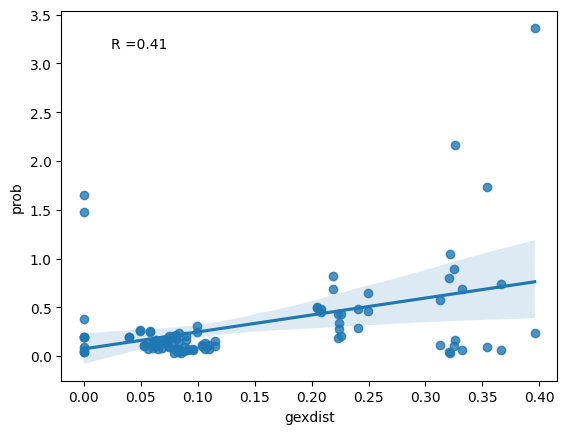

In [84]:
import seaborn, scipy

seaborn.regplot(ccbench_dist, y="prob", x="gexdist")

r, p = scipy.stats.pearsonr(x=ccbench_dist["gexdist"], y=ccbench_dist["prob"])
ax = plt.gca() # Get a matplotlib's axes instance
plt.text(.1, .9, "R ={:.2f}".format(r), transform=ax.transAxes)

# plt.savefig(f"interclustcor_gexccprob.pdf")

Text(0.1, 0.9, 'R =0.42')

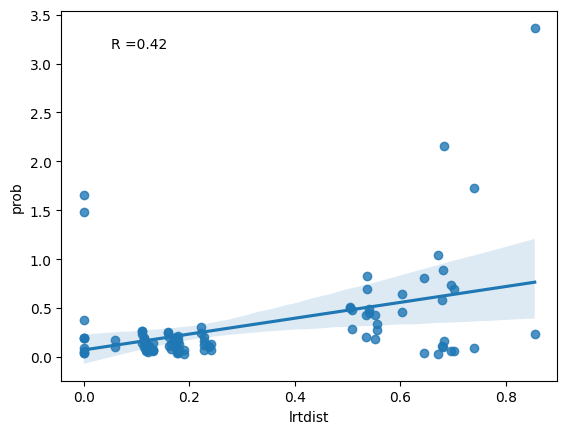

In [85]:
seaborn.regplot(ccbench_dist, y="prob", x="lrtdist")

r, p = scipy.stats.pearsonr(x=ccbench_dist["lrtdist"], y=ccbench_dist["prob"])
ax = plt.gca() # Get a matplotlib's axes instance
plt.text(.1, .9, "R ={:.2f}".format(r), transform=ax.transAxes)

# plt.savefig(f"interclustcor_lrtccprob.pdf")

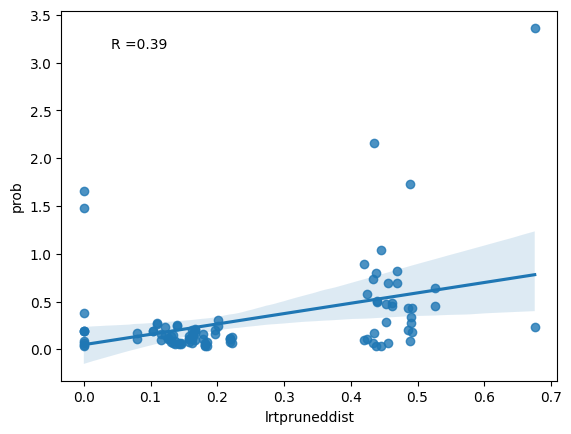

In [86]:
seaborn.regplot(ccbench_dist, y="prob", x="lrtpruneddist")

r, p = scipy.stats.pearsonr(x=ccbench_dist["lrtpruneddist"], y=ccbench_dist["prob"])
ax = plt.gca() # Get a matplotlib's axes instance
plt.text(.1, .9, "R ={:.2f}".format(r), transform=ax.transAxes)

plt.savefig(f"interclustcor_lrtprunedccprob.pdf")

Text(0.1, 0.9, 'R =0.40')

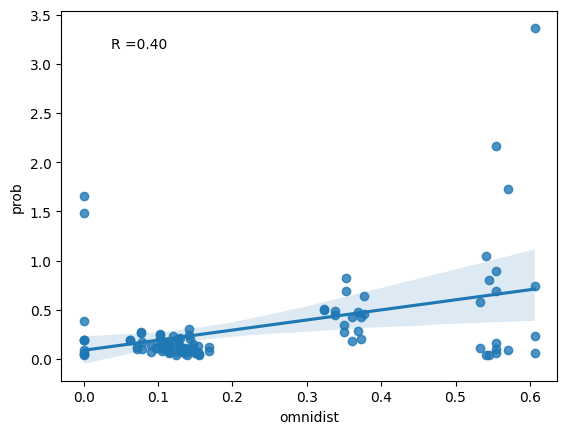

In [109]:
seaborn.regplot(ccbench_dist, y="prob", x="omnidist")

r, p = scipy.stats.pearsonr(x=ccbench_dist["omnidist"], y=ccbench_dist["prob"])
ax = plt.gca() # Get a matplotlib's axes instance
plt.text(.1, .9, "R ={:.2f}".format(r), transform=ax.transAxes)

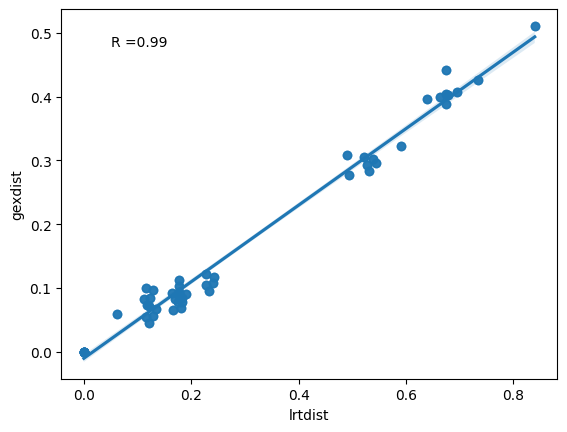

In [158]:
seaborn.regplot(ccbench_dist, x="lrtdist", y="gexdist")

r, p = scipy.stats.pearsonr(x=ccbench_dist["lrtdist"], y=ccbench_dist["gexdist"])
ax = plt.gca() # Get a matplotlib's axes instance
plt.text(.1, .9, "R ={:.2f}".format(r), transform=ax.transAxes)

# plt.savefig(f"interclustcor_lrtgex.pdf")

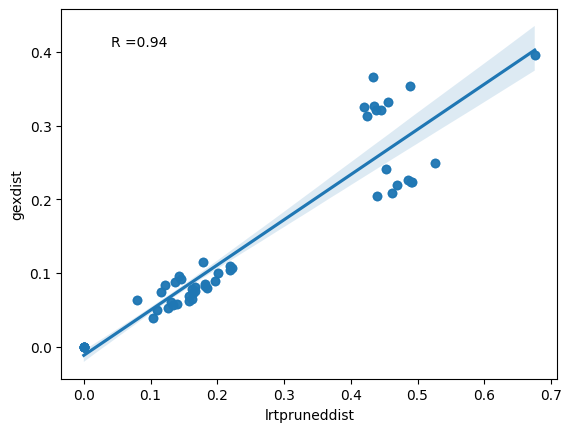

In [87]:
seaborn.regplot(ccbench_dist, x="lrtpruneddist", y="gexdist")

r, p = scipy.stats.pearsonr(x=ccbench_dist["lrtpruneddist"], y=ccbench_dist["gexdist"])
ax = plt.gca() # Get a matplotlib's axes instance
plt.text(.1, .9, "R ={:.2f}".format(r), transform=ax.transAxes)

plt.savefig(f"interclustcor_lrtprunedgex.pdf")

Text(0.1, 0.9, 'R =1.00')

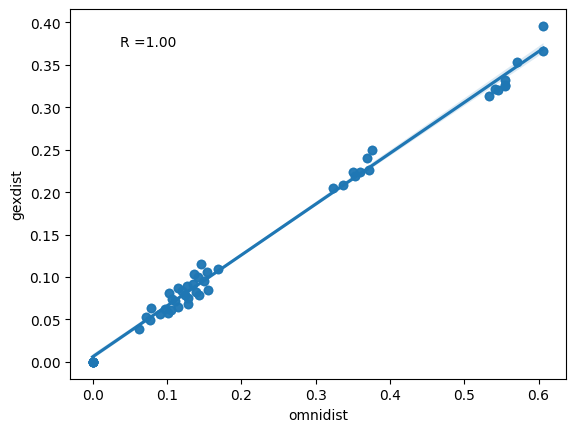

In [110]:
seaborn.regplot(ccbench_dist, x="omnidist", y="gexdist")

r, p = scipy.stats.pearsonr(x=ccbench_dist["omnidist"], y=ccbench_dist["gexdist"])
ax = plt.gca() # Get a matplotlib's axes instance
plt.text(.1, .9, "R ={:.2f}".format(r), transform=ax.transAxes)